### importing packages

In [35]:
import cobra #version 0.26.3
from cobra import Reaction, Metabolite
from cobra import flux_analysis
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

In [36]:
cobra.__version__

'0.26.3'

### importing functions

In [37]:
%run functions.py

### specifying solver

In [38]:
cobra.core.Configuration.solver = 'glpk'

### specifying day and night tag

In [39]:
# define suffices for day and night reactions and metabolites
day_tag = "_00"
night_tag = "_12"

### Loading plant model

In [40]:
cobra_model = cobra.io.read_sbml_model("PlantCoreMetabolism_v3_0_1.xml")


In [41]:
count = 0
for rxn in cobra_model.reactions:
    if 'ec-code' not in rxn.annotation and rxn.id [-2:] not in ("mc", "vc", "tx", "xc", "pc", "ec", "rc", "pr") and "biomass" not in rxn.id:
        print(rxn.id)
        count += 1
print(count)

Beta_Oxidation_x
GLUTARYL_COA_DEHYDROG_RXN_m
lycopene_biosynthesis_p
1.5.1.8_RXN_c
H_im
RXN_14903_m
MANNOSE_6_PHOSPHATE_6_REDUCTASE_RXN_c
RXN_12541_c
MALTODEG_RXN_c
RXN_13161_m
2KETO_4METHYL_PENTANOATE_DEHYDROG_RXN_m
1.1.1.178_RXN_x
SUCCINATE_COA_LIGASE_GDP_FORMING_RXN_m
GGPP_biosynthesis_p
MALATE_DEHYDROGENASE_NADP+_RXN_p
2KETO_3METHYLVALERATE_RXN_m
MANNPGUANYLTRANGDP_RXN_c
Protein_Polymerisation_c
Phytol_biosynthesis_p
RXN_11832_m
Mehler_Reaction_p
RXN_11832_p
Plastidial_ATP_Synthase_p
RXN_1781_v
Ferredoxin_Plastoquinone_Reductase_p
1.1.1.255_RXN_c
MANNITOL_1_PHOSPHATASE_RXN_c
1.2.1.25_RXN_m
HEXOKINASE_RXN_MANNOSE_c
Mitochondrial_ATP_Synthase_m
RXN_7800_p
GLUTACONYL_COA_DECARBOXYLASE_RXN_x
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x
2OXOGLUTARATEDEH_RXN_m
RXN_11213_m
GCVMULTI_RXN_m
2_KETO_ADIPATE_DEHYDROG_RXN_m
HMBPP_synthesis_p
Protein_Processing_c
A_B_oxidation_x
CYSTEINE_AMINOTRANSFERASE_RXN_m
RXN_12002_p
PROTON_ATPase_c
MDA_Fd_Ascorbate_p
MercaptoPyruvateSulfurtransferase_m
OROTATE_REDUC

In [42]:
#remove rubisco_balance metabolite from the model (balance will be reinstated later using function set_Rubisco_C_to_O_ratio)
cobra_model.metabolites.rubisco_bal_p.remove_from_model()

### Modifying plant model

#### modifying protein amino acid biomass reaction

In [43]:
#modify pHIS_biomass
"""
before:
HIS_tRNAs_c + 11.0 PROTON_c + pHIS_b <-- Charged_HIS_tRNAs_c + 9.17 PROTON_b + Protein_polymerisation_cost_c + Protein_processing_cost_c + Protein_tranlocation_cost_c + WATER_c
"""

#remove PROTON_b and set PROTON_c to -2
cobra_model.reactions.pHIS_biomass.add_metabolites({cobra_model.metabolites.PROTON_b: -9.17, cobra_model.metabolites.PROTON_c: 9.0})

"""
after:
HIS_tRNAs_c + 2.0 PROTON_c + pHIS_b <-- Charged_HIS_tRNAs_c + Protein_polymerisation_cost_c + Protein_processing_cost_c + Protein_tranlocation_cost_c + WATER_c
"""

'\nafter:\nHIS_tRNAs_c + 2.0 PROTON_c + pHIS_b <-- Charged_HIS_tRNAs_c + Protein_polymerisation_cost_c + Protein_processing_cost_c + Protein_tranlocation_cost_c + WATER_c\n'

In [44]:
cobra_model.reactions.pHIS_biomass


<Reaction pHIS_biomass at 0x7f80a847a890>

#### modifying organic acid vacuolar transport

In [45]:
# removing the MAL_CIT antiporter reaction (it is unpublished/unconfirmed) 
 #(according to Lee but what about Frei et al., 2018?)

cobra_model.reactions.MAL_CIT_vc.bounds = (0, 0)
cobra_model.reactions.MAL_CIT_rev_vc.bounds = (0, 0)

In [46]:


##changing the old fumarate vacuolar import+export reaction and adding new ones for succinate

    #the old reaction would use protons to import fumarate and use as many to export fumarate
    #Sanu and Josh have rewritten it so that import does not use protons but export requires symport of 2 protons

cobra_model.reactions.FUM_PROTON_vc.remove_from_model()


#adding the new fumarate vacuolar Import reactions


fumarate_vacuole_import = Reaction("FUM_PROTON_vc")
fumarate_vacuole_import.upper_bound = 1000.0
fumarate_vacuole_import.lower_bound = 0.0
fumarate_vacuole_import.add_metabolites({cobra_model.metabolites.FUM_c: -1,
                                          cobra_model.metabolites.FUM_v: 1,
                                          cobra_model.metabolites.PROTON_v: -0.08})
cobra_model.add_reactions([fumarate_vacuole_import])


#adding new fumarate vacuolar Export reactions

fumarate_vac_exp = Reaction("FUM_PROTON_rev_vc")
fumarate_vac_exp.upper_bound = 1000.0
fumarate_vac_exp.lower_bound = 0.0 
fumarate_vac_exp.add_metabolites({cobra_model.metabolites.FUM_c: 1,
                                  cobra_model.metabolites.FUM_v: -1,
                                  cobra_model.metabolites.PROTON_v: -1.92,
                                  cobra_model.metabolites.PROTON_c: 2})
cobra_model.add_reactions([fumarate_vac_exp])

##adding vacuolar succinate transport
#adding succinate in the vacuole

SUC_v = Metabolite("SUC_v", name="SUC_v", compartment="v", charge = -2, formula="C4H4O4")
cobra_model.add_metabolites(SUC_v)

#adding the new succinate vacuolar import reactions
#pKas from MalvinSketch T: 300, pH vacuole 5.5, pH cytosol 7.6
succinate_vacuole_import = Reaction("SUC_PROTON_vc")
succinate_vacuole_import.upper_bound = 1000.0
succinate_vacuole_import.lower_bound = 0.0 
succinate_vacuole_import.add_metabolites({cobra_model.metabolites.SUC_c: -1,
                                              cobra_model.metabolites.SUC_v: 1,
                                              cobra_model.metabolites.PROTON_v: -0.60})

cobra_model.add_reactions([succinate_vacuole_import])

#adding new succinate vacuolar export reactions

succinate_vac_exp = Reaction("SUC_PROTON_rev_vc")
succinate_vac_exp.upper_bound = 1000.0
succinate_vac_exp.lower_bound = 0.0 
succinate_vac_exp.add_metabolites({cobra_model.metabolites.SUC_c: 1,
                                              cobra_model.metabolites.SUC_v: -1,
                                              cobra_model.metabolites.PROTON_v: -1.40,
                                              cobra_model.metabolites.PROTON_c: 2})

cobra_model.add_reactions([succinate_vac_exp])

In [47]:
model = cobra_model.copy()

In [48]:
# turn off other biomass reactions
model.reactions.Biomass_tx.bounds = (0, 0)

# turn off ammonium exchange reaction
model.reactions.NH4_tx.bounds = (0, 0)

# turn of sucrose exchange reaction
model.reactions.Sucrose_tx.bounds = (0, 0)

# turn off glucose exchange reaction
model.reactions.GLC_tx.bounds = (0, 0)

# turn off unlimited proton exchange reaction
#DON'T!!

    #turn on
# model.reactions.unlProtHYPO_c.bounds = (0,1000)

#Set pG6P transporter to 0
model.reactions.get_by_id("G6P_Pi_pc").bounds = (0, 0)

#Plastid enolase was not detected in Arabidopsis mesophyll tissue
model.reactions.get_by_id("2PGADEHYDRAT_RXN_p").bounds = (0, 0)

#Setting chloroplastic NADPH dehydrogenase to 0  (Yamamoto et al., 2011)
model.reactions.get_by_id("NADPH_Dehydrogenase_p").bounds = (0, 0)

#ATP_ADP_Pi constrained to 0 because while there is evidence for its existance, it does not carry high flux
model.reactions.get_by_id("ATP_ADP_Pi_pc").bounds = (0, 0)


#turn of allantoin exchange reaction (if present)
model.reactions.Allantoin_tx.bounds = (0,0)


### creating diel model

In [49]:
# create copies of the model, naming every reaction and metabolite for day or night
day_model = retag_model_rxns_and_mets(model, day_tag)

night_model = retag_model_rxns_and_mets(model, night_tag)

In [50]:
day_model

<Model PlantCoreMetabolism_v2_1_0 at 0x7f80a7c5b3a0>

In [51]:
# merge day and night models into diel model

diel_model = day_model.merge(night_model, inplace = False)

# missing metabolites without any reactions (in some plant model versions)
"""{'3_HYDROXY_PROPIONYL_COA_m_12','ACRYLYL_COA_c_12','ACRYLYL_COA_m_12','HIS_v_12'}"""

"{'3_HYDROXY_PROPIONYL_COA_m_12','ACRYLYL_COA_c_12','ACRYLYL_COA_m_12','HIS_v_12'}"

#### creating biomass output total reactions

In [52]:
#define biomass output reaction
output_string = "AraCore_Biomass_tx"

## creating total biomass reaction

biomass_total_met = Metabolite("Biomass_output_total")
biomass_total_met.name = "Biomass_output_total"
diel_model.add_metabolites(biomass_total_met)


biomass_light_met = Metabolite("Biomass_output_light")
biomass_light_met.name = "Biomass_output_light"
diel_model.add_metabolites(biomass_light_met)

biomass_light_rxn = Reaction(output_string + "_light")
biomass_light_rxn.add_metabolites({diel_model.metabolites.Biomass_output_light: -1,
                                  diel_model.metabolites.Biomass_output_total: 1})
biomass_light_rxn.upper_bound = 1000
biomass_light_rxn.lower_bound = -1000
diel_model.add_reactions([biomass_light_rxn])

biomass_dark_met = Metabolite("Biomass_output_dark")
biomass_dark_met.name = "Biomass_output_dark"
diel_model.add_metabolites(biomass_dark_met)

biomass_dark_rxn = Reaction(output_string + "_dark")
biomass_dark_rxn.add_metabolites({diel_model.metabolites.Biomass_output_dark: -1,
                                  diel_model.metabolites.Biomass_output_total: 1})
biomass_dark_rxn.upper_bound = 1000
biomass_dark_rxn.lower_bound = -1000
diel_model.add_reactions([biomass_dark_rxn])


biomass_total_rxn = Reaction(output_string + "_total")
biomass_total_rxn.add_metabolites({diel_model.metabolites.Biomass_output_total: -1}) 
biomass_total_rxn.upper_bound = 1000
biomass_total_rxn.lower_bound = 0
diel_model.add_reactions([biomass_total_rxn])


diel_model.reactions.get_by_id(output_string+day_tag).add_metabolites({diel_model.metabolites.Biomass_output_light:1})
diel_model.reactions.get_by_id(output_string+night_tag).add_metabolites({diel_model.metabolites.Biomass_output_dark:1})

In [53]:
"""
#define phloem output reaction
phloem_output_string = "Phloem_output_tx_mod"

phloem_output_rxn = Reaction(phloem_output_string, name = "Phloem output reaction")

# phloem output reaction equation from Shameer et al., 2018 for C3 plants (tomato)
# 0.0022970297 4_AMINO_BUTYRATE_c1 + 
# 0.0004186704 ARG_c1 + 
# 0.0015049505 ASN_c1 + 
# 0.0004186704 CYS_c1 + 
# 0.0792079208 FRU_c1 + 
# 0.0693069307 GLC_c1 + 
# 0.0240792079 GLN_c1 + 
# 0.0124356436 GLT_c1 + 
# 0.0007128713 GLY_c1 + 
# 0.0004186704 HIS_c1 + 
# 0.0017425743 ILE_c1 + 
# 0.0020594059 LEU_c1 + 
# 0.0022178218 LYS_c1 + 
# 0.0038811881 L_ALPHA_ALANINE_c1 + 
# 0.006019802 L_ASPARTATE_c1 + 
# 0.0004186704 MET_c1 + 
# 0.0057029703 PHE_c1 + 
# 0.9603960396 PROTON_e1 + 
# 0.0004186704 PRO_c1 + 
# 0.003960396 SER_c1 + 
# 0.0068910891 THR_c1 + 
# 0.0004186704 TRP_c1 + 
# 0.0004186704 TYR_c1 + 
# 0.0027722772 VAL_c1 + 
# 0.7326732673 sSUCROSE_b1 
# --> 0.9603960396 PROTON_c1

phloem_output_rxn.add_metabolites({model.metabolites.get_by_id("4_AMINO_BUTYRATE_c"): -0.0022970297,
                                model.metabolites.get_by_id("ARG_c"): -0.0004186704,
                                model.metabolites.get_by_id("ASN_c"): -0.0015049505,
                                model.metabolites.get_by_id("CYS_c"): -0.0004186704,
                                model.metabolites.get_by_id("FRU_c"): -0.0792079208,
                                model.metabolites.get_by_id("GLC_c"): -0.0693069307,
                                model.metabolites.get_by_id("GLN_c"): -0.0240792079,
                                model.metabolites.get_by_id("GLT_c"): -0.0124356436,
                                model.metabolites.get_by_id("GLY_c"): -0.0007128713,
                                model.metabolites.get_by_id("HIS_c"): -0.0004186704,
                                model.metabolites.get_by_id("ILE_c"): -0.0017425743,
                                model.metabolites.get_by_id("LEU_c"): -0.0020594059,
                                model.metabolites.get_by_id("LYS_c"): -0.0022178218,
                                model.metabolites.get_by_id("L_ALPHA_ALANINE_c"): -0.0038811881,
                                model.metabolites.get_by_id("L_ASPARTATE_c"): -0.006019802,
                                model.metabolites.get_by_id("MET_c"): -0.0004186704,
                                model.metabolites.get_by_id("PHE_c"): -0.0057029703,
                                model.metabolites.get_by_id("PROTON_e"): -0.9603960396,
                                model.metabolites.get_by_id("PRO_c"): -0.0004186704,
                                model.metabolites.get_by_id("SER_c"): -0.003960396,
                                model.metabolites.get_by_id("THR_c"): -0.0068910891,
                                model.metabolites.get_by_id("TRP_c"): -0.0004186704,
                                model.metabolites.get_by_id("TYR_c"): -0.0004186704,
                                model.metabolites.get_by_id("VAL_c"): -0.0027722772,
                                model.metabolites.get_by_id("sSUCROSE_b"): -0.7326732673,
                                model.metabolites.get_by_id("PROTON_c"): 0.9603960396})


model.add_reactions([phloem_output_rxn])

phloem_day = Reaction(phloem_output_string + day_tag)
phloem_night = Reaction(phloem_output_string + night_tag)

diel_model.add_reactions([phloem_day, phloem_night])


for met in model.reactions.Phloem_output_tx_mod.metabolites:
    phloem_day.add_metabolites({diel_model.metabolites.get_by_id(met.id+day_tag): phloem_output_rxn.get_coefficient(met.id)})
    phloem_night.add_metabolites({diel_model.metabolites.get_by_id(met.id+night_tag): phloem_output_rxn.get_coefficient(met.id)})


print(phloem_day.reaction)
print(phloem_night.reaction)


## creating total phloem output reaction

phloem_total_met = Metabolite(phloem_output_string+"_total")
phloem_total_met.name = phloem_output_string+"_total"
diel_model.add_metabolites(phloem_total_met)


phloem_light_met = Metabolite(phloem_output_string+"_light")
phloem_light_met.name = phloem_output_string+"_light"
diel_model.add_metabolites(phloem_light_met)

phloem_light_rxn = Reaction(phloem_output_string + "_light")
phloem_light_rxn.add_metabolites({diel_model.metabolites.get_by_id(phloem_output_string+"_light"): -1,
                                  diel_model.metabolites.get_by_id(phloem_output_string+"_total"): 1})
phloem_light_rxn.upper_bound = 1000
phloem_light_rxn.lower_bound = -1000
diel_model.add_reactions([phloem_light_rxn])


phloem_dark_met = Metabolite(phloem_output_string+"_dark")
phloem_dark_met.name = phloem_output_string+"_dark"
diel_model.add_metabolites(phloem_dark_met)

phloem_dark_rxn = Reaction(phloem_output_string + "_dark")
phloem_dark_rxn.add_metabolites({diel_model.metabolites.get_by_id(phloem_output_string+"_dark"): -1,
                                  diel_model.metabolites.get_by_id(phloem_output_string+"_total"): 1})
phloem_dark_rxn.upper_bound = 1000
phloem_dark_rxn.lower_bound = -1000
diel_model.add_reactions([phloem_dark_rxn])


phloem_total_rxn = Reaction(phloem_output_string + "_total")
phloem_total_rxn.add_metabolites({diel_model.metabolites.get_by_id(phloem_output_string+"_total"): -1}) 
phloem_total_rxn.upper_bound = 1000
phloem_total_rxn.lower_bound = 0
diel_model.add_reactions([phloem_total_rxn])


diel_model.reactions.get_by_id(phloem_output_string+day_tag).add_metabolites({diel_model.metabolites.get_by_id(phloem_output_string+"_light"):1})
diel_model.reactions.get_by_id(phloem_output_string+night_tag).add_metabolites({diel_model.metabolites.get_by_id(phloem_output_string+"_dark"):1})

"""

'\n#define phloem output reaction\nphloem_output_string = "Phloem_output_tx_mod"\n\nphloem_output_rxn = Reaction(phloem_output_string, name = "Phloem output reaction")\n\n# phloem output reaction equation from Shameer et al., 2018 for C3 plants (tomato)\n# 0.0022970297 4_AMINO_BUTYRATE_c1 + \n# 0.0004186704 ARG_c1 + \n# 0.0015049505 ASN_c1 + \n# 0.0004186704 CYS_c1 + \n# 0.0792079208 FRU_c1 + \n# 0.0693069307 GLC_c1 + \n# 0.0240792079 GLN_c1 + \n# 0.0124356436 GLT_c1 + \n# 0.0007128713 GLY_c1 + \n# 0.0004186704 HIS_c1 + \n# 0.0017425743 ILE_c1 + \n# 0.0020594059 LEU_c1 + \n# 0.0022178218 LYS_c1 + \n# 0.0038811881 L_ALPHA_ALANINE_c1 + \n# 0.006019802 L_ASPARTATE_c1 + \n# 0.0004186704 MET_c1 + \n# 0.0057029703 PHE_c1 + \n# 0.9603960396 PROTON_e1 + \n# 0.0004186704 PRO_c1 + \n# 0.003960396 SER_c1 + \n# 0.0068910891 THR_c1 + \n# 0.0004186704 TRP_c1 + \n# 0.0004186704 TYR_c1 + \n# 0.0027722772 VAL_c1 + \n# 0.7326732673 sSUCROSE_b1 \n# --> 0.9603960396 PROTON_c1\n\nphloem_output_rxn.add_meta

#### creating linker reactions

In [54]:
linker_metabolites = {
    "STARCH_p",
    "SUCROSE_v",
    "MAL_v", #charge state
    "NITRATE_v",
    "CIT_v", #charge state


    "PHE_v",
    "GLY_v",
    "SER_v",
    "ARG_v",
    "LYS_v",
    "TYR_v",
    "ASN_v",
    "LEU_v",
    "HIS_v", #was given as bHIS_v in v2_1_0
    "ILE_v",
    "THR_v",
    "GLN_v",
    "MET_v",
    "VAL_v",
    "CYS_v",
    "PRO_v",
    "TRP_v",
    "L_ALPHA_ALANINE_v",
    "L_ASPARTATE_v",
    "GLT_v",
    "FUM_v", #charge state
    "SUC_v", #charge state

    
    "4_AMINO_BUTYRATE_v",
    "GLC_v",
    "FRU_v"
    
    
    # ,"AMMONIUM_v" #would be toxic to accumulate
    # ,"FRUCTAN_v" #was a special case for Opuntia
}
 #no proton accumulation allowed

In [55]:
#show metabolites with charge states, given by non-integer proton number

for met in diel_model.metabolites:
    try:
        if met.elements["H"] != round(met.elements["H"]):
            print(met.id,"   ", met.elements["H"])
    except:
        pass

DADP_p_00     12.21
HYDROXY_METHYL_BUTENYL_DIP_p_00     9.21
PHOSPHORIBOSYL_CARBOXY_AMINOIMIDAZOLE_p_00     11.12
SO3_m_00     0.17
SO3_p_00     0.17
CPD_11281_m_00     16.02
ADP_c_00     12.5
HISTIDINAL_p_00     9.65
CPD_5441_c_00     11.12
ADP_m_00     12.2
ADP_p_00     12.2
OXIDIZED_GLUTATHIONE_m_00     29.91
OXIDIZED_GLUTATHIONE_p_00     29.91
P_HYDROXY_PHENYLPYRUVATE_c_00     6.47
5_PHOSPHORIBOSYL_N_FORMYLGLYCINEAMIDINE_p_00     14.2
CPD_4211_p_00     9.21
PHYTYL_PYROPHOSPHATE_p_00     39.2
L_GLUTAMATE_5_P_c_00     7.09
5_PHOSPHO_RIBOSYL_GLYCINEAMIDE_p_00     13.58
DATP_p_00     12.21
DUTP_p_00     11.19
UTP_p_00     12.18
DGTP_p_00     11.7
CDP_p_00     12.21
CDP_m_00     12.21
UTP_c_00     11.5
MAL_v_00     4.3
ATP_p_00     12.1
ATP_m_00     12.1
ATP_c_00     12.35
ATP_x_00     12.35
CYS_m_00     6.92
FUM_v_00     2.08
Pi_x_00     1.3
GMP_p_00     11.5
GMP_c_00     11.87
CTP_m_00     12.21
CTP_p_00     12.21
DGDP_p_00     11.7
DCTP_p_00     12.21
GDP_c_00     12.5
Pi_c_00     1.

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 12.21 is not an integer (in formula C10H12.21N5O9P2)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 9.21 is not an integer (in formula C5H9.21O8P2)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 11.12 is not an integer (in formula C9H11.12N3O9P)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 0.17 is not an integer (in formula O3S1H0.17)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolit

In [56]:
for linker_met in linker_metabolites:
      temp_linker_dn = Reaction(linker_met + "_linker_00_to_12")
      temp_linker_dn.name = linker_met + "_linker_day_to_night"
      temp_linker_dn.upper_bound = 1000.0
      temp_linker_dn.lower_bound = 0
      temp_linker_dn.add_metabolites({diel_model.metabolites.get_by_id(linker_met+"_00"): -1, 
                                    diel_model.metabolites.get_by_id(linker_met+"_12"): 1})
      diel_model.add_reactions([temp_linker_dn])
  
  
      temp_linker_nd = Reaction(linker_met + "_linker_12_to_00")
      temp_linker_nd.name = linker_met + "_linker_night_to_day"
      temp_linker_nd.upper_bound = 1000.0
      temp_linker_nd.lower_bound = 0
      temp_linker_nd.add_metabolites({diel_model.metabolites.get_by_id(linker_met+"_12"): -1, 
                                    diel_model.metabolites.get_by_id(linker_met+"_00"): 1})
      diel_model.add_reactions([temp_linker_nd])


### Setting constraints

In [57]:
#turn off chlorophyll a/b cycling for energy dissipation
diel_model.reactions.get_by_id("RXN_7674_p_00").bounds = (0, 0)

#turn off cytosolic ferric chelate reductase cycle for NADH dissipation
diel_model.reactions.get_by_id("FERRIC_CHELATE_REDUCTASE_RXN_c_00").bounds = (0, 0)

#Turn off PTOX
diel_model.reactions.get_by_id("Plastoquinol_Oxidase_p_00").bounds = (0, 0)

#### Create pseudocompartment for constraint metabolites

In [58]:
diel_model.metabolites.Biomass_output_light.compartment = "pseudo_compartment"
diel_model.metabolites.Biomass_output_dark.compartment = "pseudo_compartment"
diel_model.metabolites.Biomass_output_total.compartment = "pseudo_compartment"
diel_model.metabolites.Phloem_output_tx_mod_total.compartment = "pseudo_compartment"
diel_model.metabolites.Phloem_output_tx_mod_light.compartment = "pseudo_compartment"
diel_model.metabolites.Phloem_output_tx_mod_dark.compartment = "pseudo_compartment"

AttributeError: DictList has no attribute or entry Phloem_output_tx_mod_total

In [ ]:
diel_model.reactions.RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p_12.upper_bound = 0

In [ ]:
diel_model.reactions.CO2_tx_12.upper_bound = 0
diel_model.reactions.CO2_tx_12.lower_bound = -1000

In [ ]:
cobra.io.write_sbml_model(diel_model, "diel_plant_core_model.xml")

## Optimisation of basic diel plant model

In [ ]:
diel_model_test = diel_model.copy()

objective = diel_model_test.reactions.get_by_id(output_string +"_total")
diel_model_test.objective = {objective : 1}

solution_diel_test = flux_analysis.parsimonious.pfba(diel_model_test)

In [ ]:
solution_diel_test

<Solution 17238.142 at 0x7f80a92b9720>

In [ ]:
diel_model_test.reactions.get_by_id(output_string +"_total").flux

1.8301753331565807

In [ ]:
model_results_overview(diel_model_test, solution_diel_test, output_string+"_total")

Photon uptake = 1000.0   % of allowed Photon uptake = 100.0
Output rate (AraCore_Biomass_tx_total) 1.8302		sum of fluxes: 17238.1418
gas exchange = Day: 158.57812 Night: 0.0
CCE: 1.0
ATPase: 0.0 0.0
Rubisco Carbox./Oxygen. = 152.2598/0.0

Linker fluxes 		 Day 	 Night
VAL_v_linker                         0.0                 0.0

NITRATE_v_linker                     0.0                 0.0

CIT_v_linker                    25.65191                 0.0

PHE_v_linker                         0.0                 0.0

STARCH_p_linker                      0.0             7.41172

LYS_v_linker                         0.0                 0.0

MET_v_linker                         0.0                 0.0

MAL_v_linker                         0.0                 0.0

CYS_v_linker                         0.0                 0.0

4_AMINO_BUTYRATE_v_linker                 0.0                 0.0

L_ASPARTATE_v_linker                 0.0                 0.0

L_ALPHA_ALANINE_v_linker                 0.0 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")


In [ ]:
calculate_noct_CO2_refixation_coefficient(diel_model_test, verbose=True)

----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	16.534434
consuming CO2:	RXN0_5224_c_12	16.534434
consuming CO2:	CO2_pc_12	-17.192561
producing CO2:	ISOCITDEH_RXN_c_12	9.282049
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	2.077142
producing CO2:	GLUTDECARBOX_RXN_c_12	0.176355
producing CO2:	CO2_mc_12	21.454285
consuming HCO3-:	PEPCARBOX_RXN_c_12	16.534434
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.302718
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.434446
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.469334
producing CO2:	RXN_9652_p_12	1.411344
producing CO2:	ACETOOHBUTSYN_RXN_p_12	0.301852
producing CO2:	RXN_9650_p_12	1.411344
producing CO2:	2.3.1.180_RXN_p_12	1.411344
producing CO2:	RXN_9654_p_12	1.411344
producing HCO3-:	RXN0_5224_p_12	15.568413
consuming CO2:	RXN0_5224_p_12	15.568413
producing CO2:	CO2_pc_12	-17.192561
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	9.879409
producing CO2:	RXN_9653_p_12	1.411344
producing CO2:	RXN_9

0.9999999999999967

In [ ]:
calculate_CO2_refixation_coefficient(diel_model_test, verbose=True)

----- Cytosol -----
consuming CO2:	RXN0_5224_c_12	16.534434
consuming CO2:	CO2_pc_12	-17.192561
producing CO2:	ISOCITDEH_RXN_c_12	9.282049
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	2.077142
producing CO2:	GLUTDECARBOX_RXN_c_12	0.176355
producing CO2:	CO2_mc_12	21.454285
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.302718
producing CO2:	PREPHENATEDEHYDRAT_RXN_c_12	0.434446
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.469334
producing CO2:	RXN_9652_p_12	1.411344
producing CO2:	ACETOOHBUTSYN_RXN_p_12	0.301852
producing CO2:	RXN_9650_p_12	1.411344
producing CO2:	2.3.1.180_RXN_p_12	1.411344
producing CO2:	RXN_9654_p_12	1.411344
consuming CO2:	RXN0_5224_p_12	15.568413
producing CO2:	CO2_pc_12	-17.192561
producing CO2:	RXN_9653_p_12	1.411344
producing CO2:	RXN_9651_p_12	1.411344
consuming CO2:	CARBAMATE_KINASE_RXN_p_12	12.845834
producing CO2:	RXN_9648_p_12	1.411344
producing CO2:	ACETOLACTSYN_RXN_p_12	0.571091
----- Mitochondrion -----
producing CO2:

0.9999999999999967

In [ ]:
calculate_CO2_refixation_coefficient(model_no_cetch, verbose=True, time_tag="_00")

NameError: name 'model_no_cetch' is not defined

In [ ]:
calc_carbon_flux(model_no_cetch, output_string=output_string)

CO2 daytime exchange: 179.02212573432
CO2 nightime exchange: -10.718272589587755
CO2 respiratory losses: 0 (no CO2_m_00 found)
Carbon day to night: 374.0167832231911
Carbon night to day: 194.99465748887206
CO2 exchange night:day: 0.5213526938776722
AraCore_Biomass_tx_00 carbon flux: -0.0
AraCore_Biomass_tx_12 carbon flux: -168.30385314473097
total carbon biomass flux: -168.30385314473097
total CCE: 0.9401287827098291
nCO2RC: 0.7894665566006939
night CCE: 0.4499901092521219


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 4.3 is not an integer (in formula C4H4.3O5)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 2.08 is not an integer (in formula C4H2.08O4)
  warn(f"{count} is not an integer (in formula {self.formula})")
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cobra/core/metabolite.py:146: UserWarning: 5.5 is not an integer (in formula C6H5.5O7)
  warn(f"{count} is not an integer (in formula {self.formula})")


value
CO2 daytime exchange       179.022126
CO2 nightime exchange      -10.718273
Carbon day to night        374.016783
Carbon night to day        194.994657
CO2 exchange night:day       0.521353
day carbon biomass flux      0.000000
night carbon biomass flux  168.303853
total Carbon biomass flux  168.303853
total CCE                    0.940129
nCO2RC                       0.789467
% nCO2R                     78.946656
night CCE                    0.449990

In [ ]:
model_no_cetch.reactions.get_by_id(output_string +"_total").flux

1.942421564513109

## CO2 Scan


In [ ]:
df_diel_model_CAM, solution_diel_model_CAM = parameter_scan_CO2(diel_model, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)



Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total


Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
----- Plastid -----
----- Mitochondrion -----
----- Peroxisome -----

CO2 produced: 0
CO2 consumed: 0
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 0
CO2_tx_00 = 0
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0115412
----- Cytosol -----
----- Plastid -----
----- Mitochondrion -----
----- Peroxisome -----

CO2 produced: 0
CO2 consumed: 0
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 0
------- Scan iteration: 3      Scan value: 2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0230823
----- Cytosol -----
----- Plastid -----
----- Mitochondrion -----
----- Peroxisome -----

CO2 produced: 0
CO2 consumed: 0
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 0
------- Scan iteration: 4      Scan value: 3 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx

In [ ]:
df_diel_model_obj, solution_diel_model_obj = parameter_scan_CO2(diel_model, output_string+"_total", output_string+"_total", 
                   0, 0.3, 0.01, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)


Scanning process: AraCore_Biomass_tx_total 

------- Scan iteration: 1      Scan value: 0.0 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
----- Plastid -----
----- Mitochondrion -----
----- Peroxisome -----

CO2 produced: 0
CO2 consumed: 0
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 0
CO2_tx_00 = 0
------- Scan iteration: 2      Scan value: 0.01 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.01
----- Cytosol -----
----- Plastid -----
----- Mitochondrion -----
----- Peroxisome -----

CO2 produced: 0.0
CO2 consumed: -0.0
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 1.0
------- Scan iteration: 3      Scan value: 0.02 (AraCore_Biomass_tx_total) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.02
----- Cytosol -----
----- Plastid -----
----- Mitochondrion -----
----- Perox

0.011541159208296565 1.3877787807814457e-17


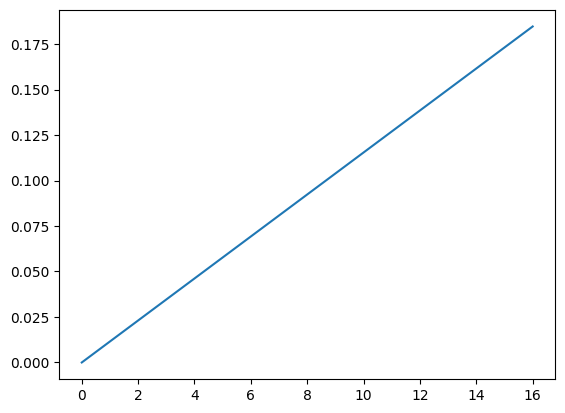

In [ ]:
x1 = df_diel_model_CAM.transpose()["CO2_tx_00"]
y1 = df_diel_model_CAM.transpose()[output_string+"_total"]

# Calculate slope using linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)

print(slope, intercept)
plt.plot(x1, y1)

0.01154115920829658 -2.7755575615628914e-17


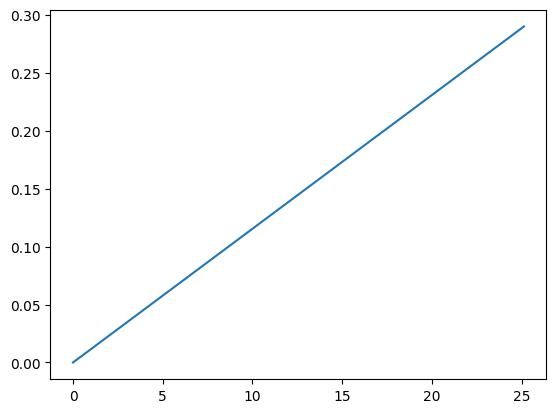

In [ ]:
x2 = df_diel_model_obj.transpose()["CO2_tx_00"]
y2 = df_diel_model_obj.transpose()[output_string+"_total"]

# Calculate slope using linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x2, y2)

print(slope, intercept)
plt.plot(x2, y2)

In [ ]:
df_diel_model_double_ub, solution_diel_model_double_ub = parameter_scan_CO2(diel_model, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50, double_ub=True, m=0.009814709555604692 , b=-0.012822097547840694)



Scanning process: CO2_tx_00 



------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Model iteration is infeasible!
------- Scan iteration: 3      Scan value: 2 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0068073
----- Cytosol -----
----- Plastid -----
----- Mitochondrion -----
----- Peroxisome -----

CO2 produced: 0.0
CO2 consumed: -0.0
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 1.0
------- Scan iteration: 4      Scan value: 3 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.016622
----- Cytosol -----
----- Plastid -----
----- Mitochondrion -----
----- Peroxisome -----

CO2 produced: 0.0
CO2 consumed: -0.0
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 1.0
------- Scan iteration: 5      Scan value: 4 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible.

0.011488645299221856 0.0


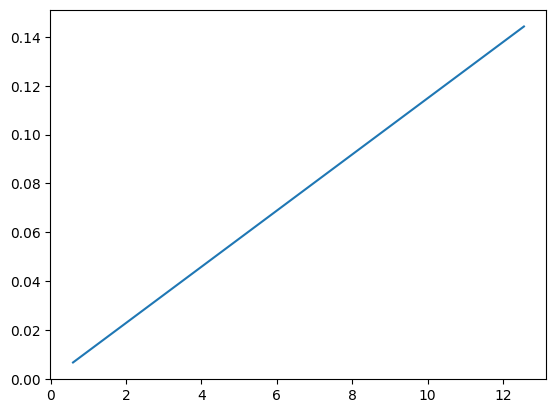

In [ ]:
x3 = df_diel_model_double_ub.transpose()["CO2_tx_00"]
y3 = df_diel_model_double_ub.transpose()[output_string+"_total"]

x3 = x3.dropna()
y3 = y3.dropna()

# Calculate slope using linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x3, y3)
print(slope, intercept)
plt.plot(x3, y3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


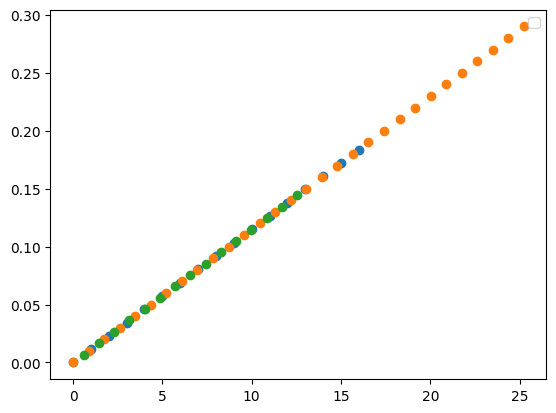

In [ ]:
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter(x3, y3)
plt.legend()

In [ ]:
df_diel_model_double_ub.transpose()[["CO2_tx_00", output_string+"_total", "ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12"]]

reactions  CO2_tx_00  AraCore_Biomass_tx_total  \
0                NaN                       NaN   
1                NaN                       NaN   
2           0.592526                  0.006807   
3           1.446823                  0.016622   
4           2.301119                  0.026437   
5           3.155416                  0.036251   
6           4.009712                  0.046066   
7           4.864009                  0.055881   
8           5.718305                  0.065696   
9           6.572602                  0.075510   
10          7.426898                  0.085325   
11          8.281195                  0.095140   
12          9.135491                  0.104954   
13          9.989788                  0.114769   
14         10.844084                  0.124584   
15         11.698381                  0.134399   
16         12.552677                  0.144213   

reactions  ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12  
0                                           NaN  
1                                           NaN  
2                                 -2.475446e-17  
3                                 -5.946682e-17  
4                                 -9.593232e-17  
5                                 -1.295928e-16  
6                                 -1.671803e-16  
7                                 -2.030848e-16  
8                                 -2.345012e-16  
9                                 -2.659176e-16  
10                                -2.962121e-16  
11                                -3.444587e-16  
12                                -3.747531e-16  
13                                -4.196338e-16  
14                                -4.476841e-16  
15                                -4.824666e-16  
16                                -5.116390e-16

In [ ]:
df_diel_model_obj.transpose()[["CO2_tx_00", output_string+"_total", "ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12"]]

reactions  CO2_tx_00  AraCore_Biomass_tx_total  \
0.0         0.000000                      0.00   
0.01        0.870425                      0.01   
0.02        1.740849                      0.02   
0.03        2.611274                      0.03   
0.04        3.481699                      0.04   
0.05        4.352123                      0.05   
0.06        5.222548                      0.06   
0.07        6.092973                      0.07   
0.08        6.963397                      0.08   
0.09        7.833822                      0.09   
0.1         8.704246                      0.10   
0.11        9.574671                      0.11   
0.12       10.445096                      0.12   
0.13       11.315520                      0.13   
0.14       12.185945                      0.14   
0.15       13.056370                      0.15   
0.16       13.926794                      0.16   
0.17       14.797219                      0.17   
0.18       15.667644                      0.18   
0.19       16.538068                      0.19   
0.2        17.408493                      0.20   
0.21       18.278918                      0.21   
0.22       19.149342                      0.22   
0.23       20.019767                      0.23   
0.24       20.890191                      0.24   
0.25       21.760616                      0.25   
0.26       22.631041                      0.26   
0.27       23.501465                      0.27   
0.28       24.371890                      0.28   
0.29       25.242315                      0.29   

reactions  ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12  
0.0                                0.000000e+00  
0.01                              -3.534349e-17  
0.02                              -7.068697e-17  
0.03                              -1.077135e-16  
0.04                              -1.413739e-16  
0.05                              -1.817665e-16  
0.06                              -2.154270e-16  
0.07                              -2.513314e-16  
0.08                              -2.827479e-16  
0.09                              -3.242625e-16  
0.1                               -3.635330e-16  
0.11                              -3.893393e-16  
0.12                              -4.308539e-16  
0.13                              -4.577823e-16  
0.14                              -5.026629e-16  
0.15                              -5.295913e-16  
0.16                              -5.654958e-16  
0.17                              -6.148644e-16  
0.18                              -6.485249e-16  
0.19                              -6.799413e-16  
0.2                               -7.270660e-16  
0.21                              -7.405302e-16  
0.22                              -7.786787e-16  
0.23                              -8.100951e-16  
0.24                              -8.617078e-16  
0.25                              -9.043444e-16  
0.26                              -9.155646e-16  
0.27                              -9.649332e-16  
0.28                              -1.005326e-15  
0.29                              -1.054694e-15

In [ ]:
x1 = df_diel_model_CAM.transpose()["CO2_tx_00"]
z1 = df_diel_model_CAM.transpose()["ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12"]

x2 = df_diel_model_obj.transpose()["CO2_tx_00"]
z2 = df_diel_model_obj.transpose()["ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12"]

x3 = df_diel_model_double_ub.transpose()["CO2_tx_00"]
z3 = df_diel_model_double_ub.transpose()["ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12"]

x4 = df_diel_model_CO2.transpose()["CO2_tx_00"]
y4 = df_diel_model_CO2.transpose()[output_string+"_total"]
z4 = df_diel_model_CO2.transpose()["ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12"]

x3 = x3.dropna()
z3 = z3.dropna()
# plt.scatter(x1, y1)
# plt.scatter(x2, y2)
# plt.scatter(x3, y3)
# plt.scatter(x4, y4)
plt.scatter(x1, z1)
plt.scatter(x2, z2)
plt.scatter(x3, z3)
plt.scatter(x4, z4)
plt.legend()

NameError: name 'df_diel_model_CO2' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.020544374004343842 -0.03085100339487931


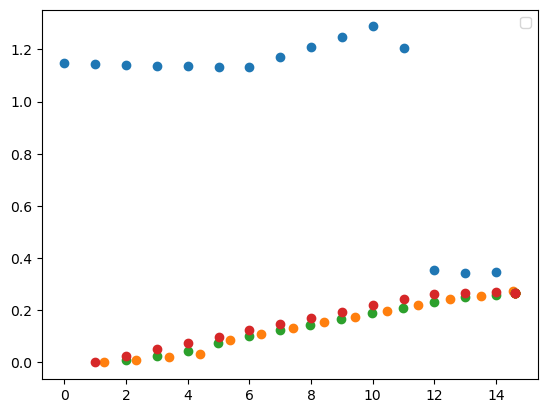

In [ ]:
x1 = df_diel_model_CAM.transpose()["CO2_tx_00"]
z1 = df_diel_model_CAM.transpose()["PEPCARBOX_RXN_c_12"]

x2 = df_diel_model_obj.transpose()["CO2_tx_00"]
z2 = df_diel_model_obj.transpose()["PEPCARBOX_RXN_c_12"]

x3 = df_diel_model_double_ub.transpose()["CO2_tx_00"]
z3 = df_diel_model_double_ub.transpose()["PEPCARBOX_RXN_c_12"]

x4 = df_diel_model_CO2.transpose()["CO2_tx_00"]
y4 = df_diel_model_CO2.transpose()[output_string+"_total"]
z4 = df_diel_model_CO2.transpose()["PEPCARBOX_RXN_c_12"]

x3 = x3.dropna()
z3 = z3.dropna()
# plt.scatter(x1, y1)
# plt.scatter(x2, y2)
# plt.scatter(x3, y3)
# plt.scatter(x4, y4)
plt.scatter(x1, z1)
plt.scatter(x2, z2)
plt.scatter(x3, z3)
plt.scatter(x4, z4)
plt.legend()

# Calculate slope using linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x2, z2)

print(slope, intercept)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.1511601706784647 -0.002863778386600152


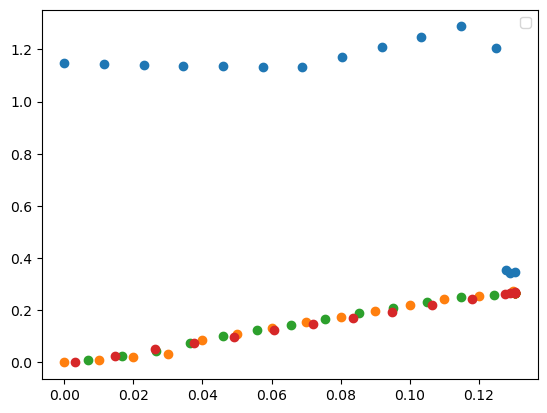

In [ ]:
x1 = df_diel_model_CAM.transpose()[output_string+"_total"]
z1 = df_diel_model_CAM.transpose()["PEPCARBOX_RXN_c_12"]

x2 = df_diel_model_obj.transpose()[output_string+"_total"]
z2 = df_diel_model_obj.transpose()["PEPCARBOX_RXN_c_12"]

x3 = df_diel_model_double_ub.transpose()[output_string+"_total"]
z3 = df_diel_model_double_ub.transpose()["PEPCARBOX_RXN_c_12"]

x4 = df_diel_model_CO2.transpose()[output_string+"_total"]
z4 = df_diel_model_CO2.transpose()["PEPCARBOX_RXN_c_12"]

x3 = x3.dropna()
z3 = z3.dropna()
# plt.scatter(x1, y1)
# plt.scatter(x2, y2)
# plt.scatter(x3, y3)
# plt.scatter(x4, y4)
plt.scatter(x1, z1)
plt.scatter(x2, z2)
plt.scatter(x3, z3)
plt.scatter(x4, z4)
plt.legend()

# Calculate slope using linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x3, z3)

print(slope, intercept)

In [ ]:
df_diel_model_double_ub.transpose()[output_string+"_total"]

0          NaN
1          NaN
2     0.006807
3     0.016622
4     0.026437
5     0.036251
6     0.046066
7     0.055881
8     0.065696
9     0.075510
10    0.085325
11    0.095140
12    0.104954
13    0.114769
14    0.124584
15    0.130622
16    0.130622
Name: AraCore_Biomass_tx_total, dtype: float64

In [ ]:
df_diel_model_CAM.tail(20)

0            1            2            3  \
reactions                                                                       
CIT_v_linker_12_to_00        -0.000000    -0.074750    -0.149500    -0.224250   
VAL_v_linker_00_to_12         0.000000     0.000000     0.000000     0.000000   
VAL_v_linker_12_to_00        -0.000000    -0.000000    -0.000000    -0.000000   
GLY_v_linker_00_to_12         0.000000     0.000000     0.000000     0.000000   
GLY_v_linker_12_to_00        -0.000000    -0.000000    -0.000000    -0.000000   
SUCROSE_v_linker_00_to_12     0.000000     0.000000     0.000000     0.000000   
SUCROSE_v_linker_12_to_00    -0.000000    -0.000000    -0.000000    -0.000000   
LYS_v_linker_00_to_12         0.000000     0.000000     0.000000     0.000000   
LYS_v_linker_12_to_00        -0.000000    -0.000000    -0.000000    -0.000000   
CO2_m_00                      0.000000     0.000000     0.000000     0.000000   
noct. CO2 coeff.              1.000000     1.000000     1.000000     1.000000   
CCE                           1.000000     1.000000     1.000000     1.000000   
sum of fluxes               262.168803   362.392308   463.582383   564.773249   
photon use                    0.135748     0.214147     0.293516     0.372991   
growth rate ub             1000.000000  1000.000000  1000.000000  1000.000000   
photon use ub               200.000000   200.000000   200.000000   200.000000   
daytime CO2 uptake ub         0.000000     1.000000     2.000000     3.000000   
scan process ub               0.000000     1.000000     2.000000     3.000000   
total aa day                  0.000000     0.022160     0.044321     0.066481   
total aa night               -0.000000    -0.000000    -0.000000    -0.000000   

                                      4            5            6  \
reactions                                                           
CIT_v_linker_12_to_00     -2.990000e-01    -0.373750    -0.448500   
VAL_v_linker_00_to_12     -3.813220e-18     0.000000     0.004871   
VAL_v_linker_12_to_00     -0.000000e+00    -0.000000    -0.000000   
GLY_v_linker_00_to_12      0.000000e+00     0.000000     0.000000   
GLY_v_linker_12_to_00     -0.000000e+00    -0.000000    -0.000000   
SUCROSE_v_linker_00_to_12  0.000000e+00     0.000000     0.000000   
SUCROSE_v_linker_12_to_00 -0.000000e+00    -0.000000    -0.000000   
LYS_v_linker_00_to_12     -4.421936e-18     0.000000     0.000000   
LYS_v_linker_12_to_00     -0.000000e+00    -0.000000    -0.000000   
CO2_m_00                   0.000000e+00     0.000000     0.000000   
noct. CO2 coeff.           1.000000e+00     1.000000     1.000000   
CCE                        1.000000e+00     1.000000     1.000000   
sum of fluxes              6.659743e+02   767.175326   868.546253   
photon use                 4.538286e-01     0.534666     0.615828   
growth rate ub             1.000000e+03  1000.000000  1000.000000   
photon use ub              2.000000e+02   200.000000   200.000000   
daytime CO2 uptake ub      4.000000e+00     5.000000     6.000000   
scan process ub            4.000000e+00     5.000000     6.000000   
total aa day               8.864190e-02     0.110802     0.132963   
total aa night            -0.000000e+00    -0.000000    -0.000000   

                                     7            8            9           10  \
reactions                                                                       
CIT_v_linker_12_to_00        -0.453050    -0.456986    -0.467229    -0.471866   
VAL_v_linker_00_to_12         0.006347     0.007254     0.008160     0.009067   
VAL_v_linker_12_to_00        -0.000000    -0.000000    -0.000000    -0.000000   
GLY_v_linker_00_to_12         0.000000     0.000000     0.000000     0.000000   
GLY_v_linker_12_to_00        -0.000000    -0.000000    -0.000000    -0.000000   
SUCROSE_v_linker_00_to_12     0.000000     0.000000     0.003634     0.004037   
SUCROSE_v_linker_12_to_00    -0.000000    -0.000000    -0.000000    -0.000000   
LYS_v_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


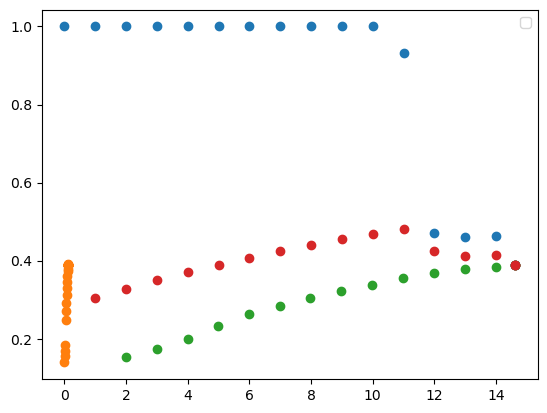

In [ ]:
x1 = df_diel_model_CAM.transpose()["CO2_tx_00"]
z1 = df_diel_model_CAM.transpose()["noct. CO2 coeff."]

z2 = df_diel_model_obj.transpose()["CO2_tx_00"]
z2 = df_diel_model_obj.transpose()["noct. CO2 coeff."]

x3 = df_diel_model_double_ub.transpose()["CO2_tx_00"]
z3 = df_diel_model_double_ub.transpose()["noct. CO2 coeff."]

x4 = df_diel_model_CO2.transpose()["CO2_tx_00"]
y4 = df_diel_model_CO2.transpose()[output_string+"_total"]
z4 = df_diel_model_CO2.transpose()["noct. CO2 coeff."]

x3 = x3.dropna()
z3 = z3.dropna()
# plt.scatter(x1, y1)
# plt.scatter(x2, y2)
# plt.scatter(x3, y3)
# plt.scatter(x4, y4)
plt.scatter(x1, z1)
plt.scatter(x2, z2)
plt.scatter(x3, z3)
plt.scatter(x4, z4)
plt.legend()

In [ ]:
df_diel_model_CAM.transpose()[output_string+"_total"]

0     0.000000
1     0.011489
2     0.022977
3     0.034466
4     0.045955
5     0.057443
6     0.068932
7     0.080421
8     0.091909
9     0.103398
10    0.114886
11    0.124977
12    0.127838
13    0.129178
14    0.130512
15    0.130622
16    0.130622
Name: AraCore_Biomass_tx_total, dtype: float64

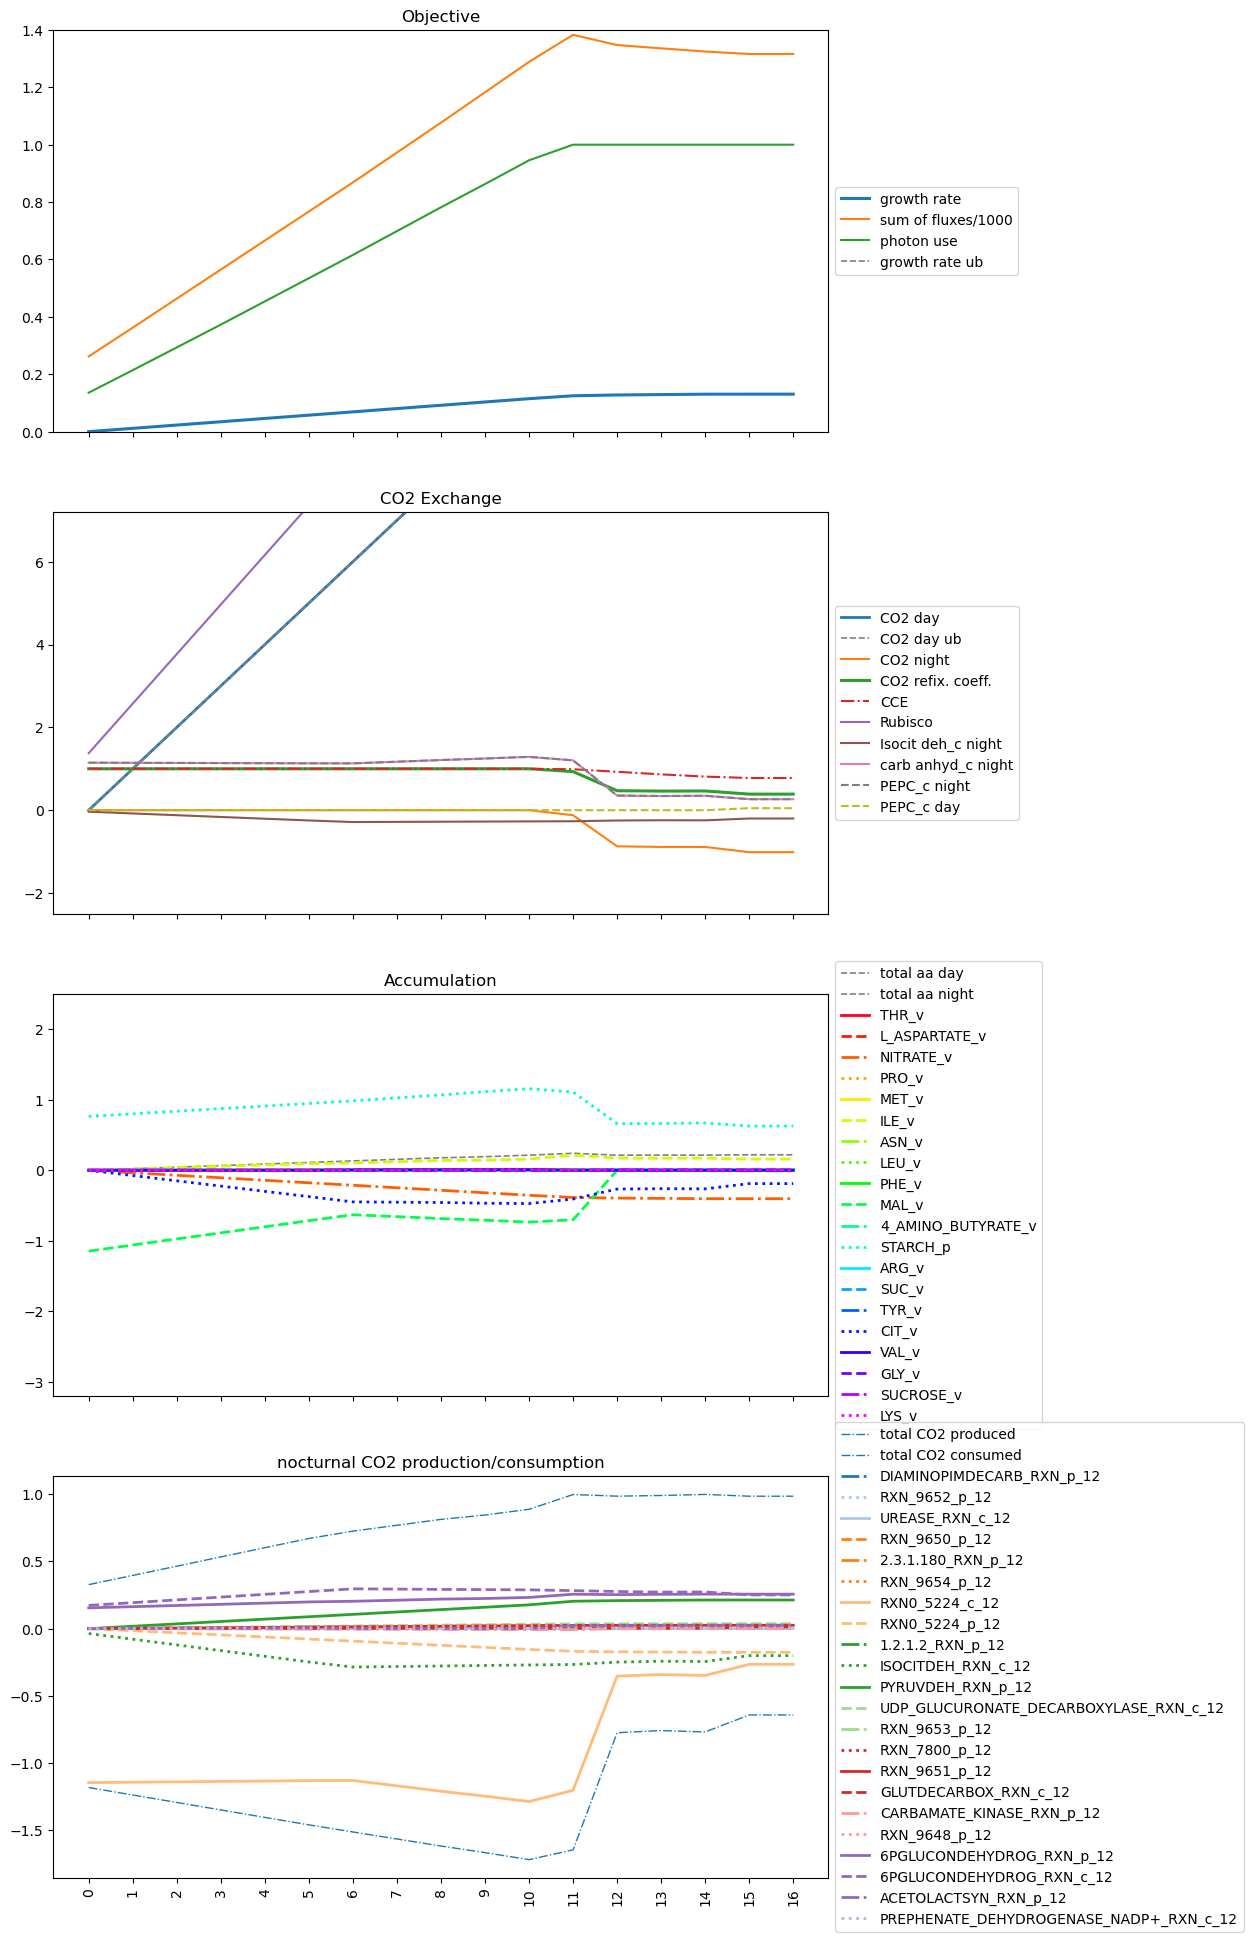

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_CAM, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c", "_p"])

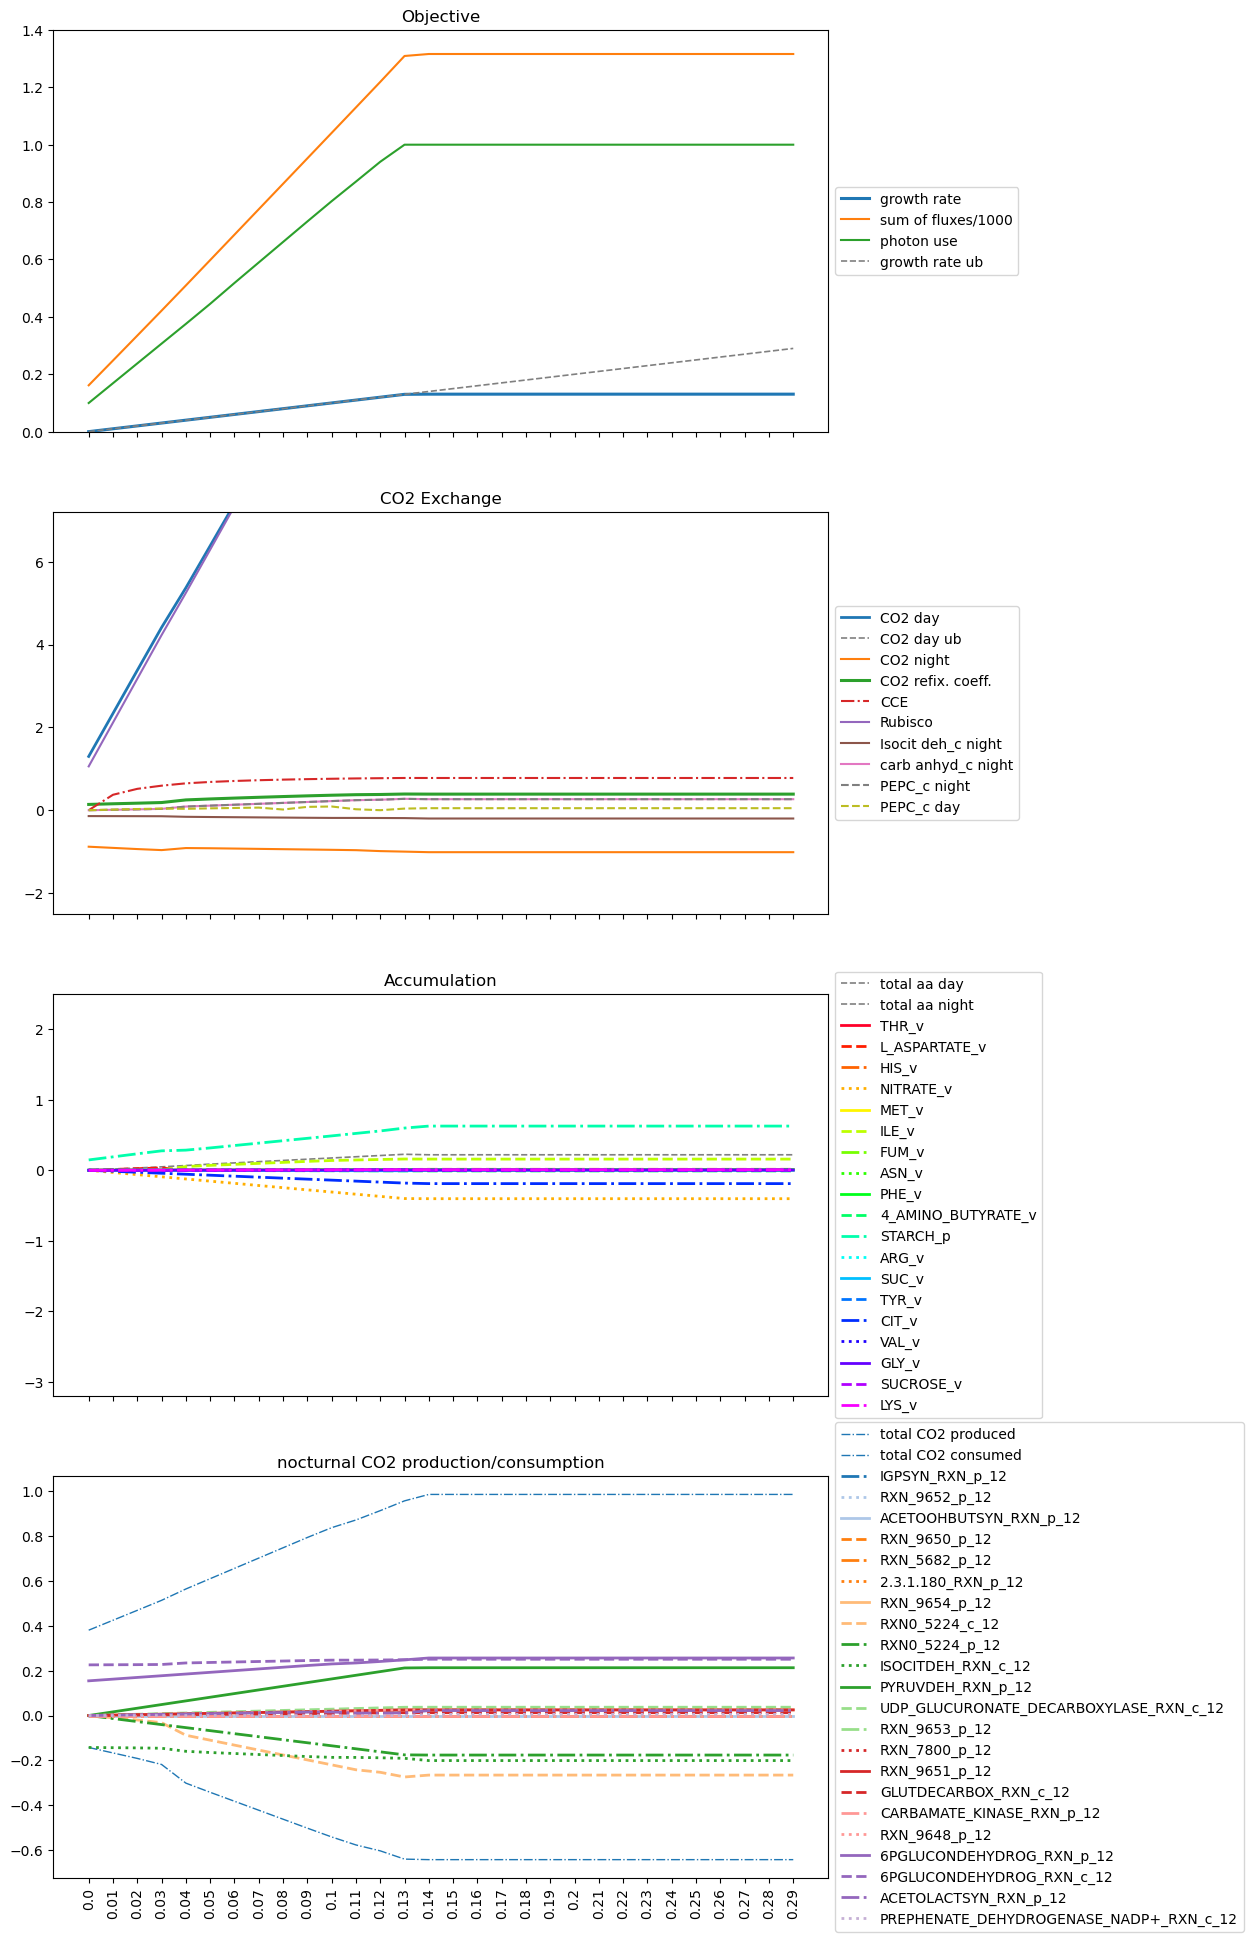

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_obj, 0.00001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c", "_p"])

In [ ]:
diel_model_CO2.reactions.PEPCARBOX_RXN_c_12

<Reaction PEPCARBOX_RXN_c_12 at 0x7fd352315eb0>

In [ ]:
diel_model_CO2 = diel_model.copy()
diel_model_CO2.reactions.PEPCARBOX_RXN_c_12.upper_bound = 0
diel_model_CO2.reactions.PEPCARBOX_RXN_p_12.upper_bound = 0


df_diel_model_CO2, solution_diel_model_CO2 = parameter_scan_CO2(diel_model_CO2, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0031747
----- Cytosol -----
producing CO2:	CO2_pc_12	0.162578
consuming CO2:	ISOCITDEH_RXN_c_12	-0.308453
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.000901
producing CO2:	CO2_mc_12	0.868638
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.00021
producing CO2:	RXN_9652_p_12	0.000612
producing CO2:	RXN_9650_p_12	0.000612
producing CO2:	RXN_5682_p_12	0.000135
producing CO2:	2.3.1.180_RXN_p_12	0.000612
producing CO2:	RXN_9654_p_12	0.000612
producing HCO3-:	RXN0_5224_p_12	0.004284
consuming CO2:	RXN0_5224_p_12	0.004284
consuming CO2:	CO2_pc_12	0.162578
producing CO2:	1.2.1.2_RXN_p_12	0.000103
consuming HCO3-:	ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12	0.004284
produc

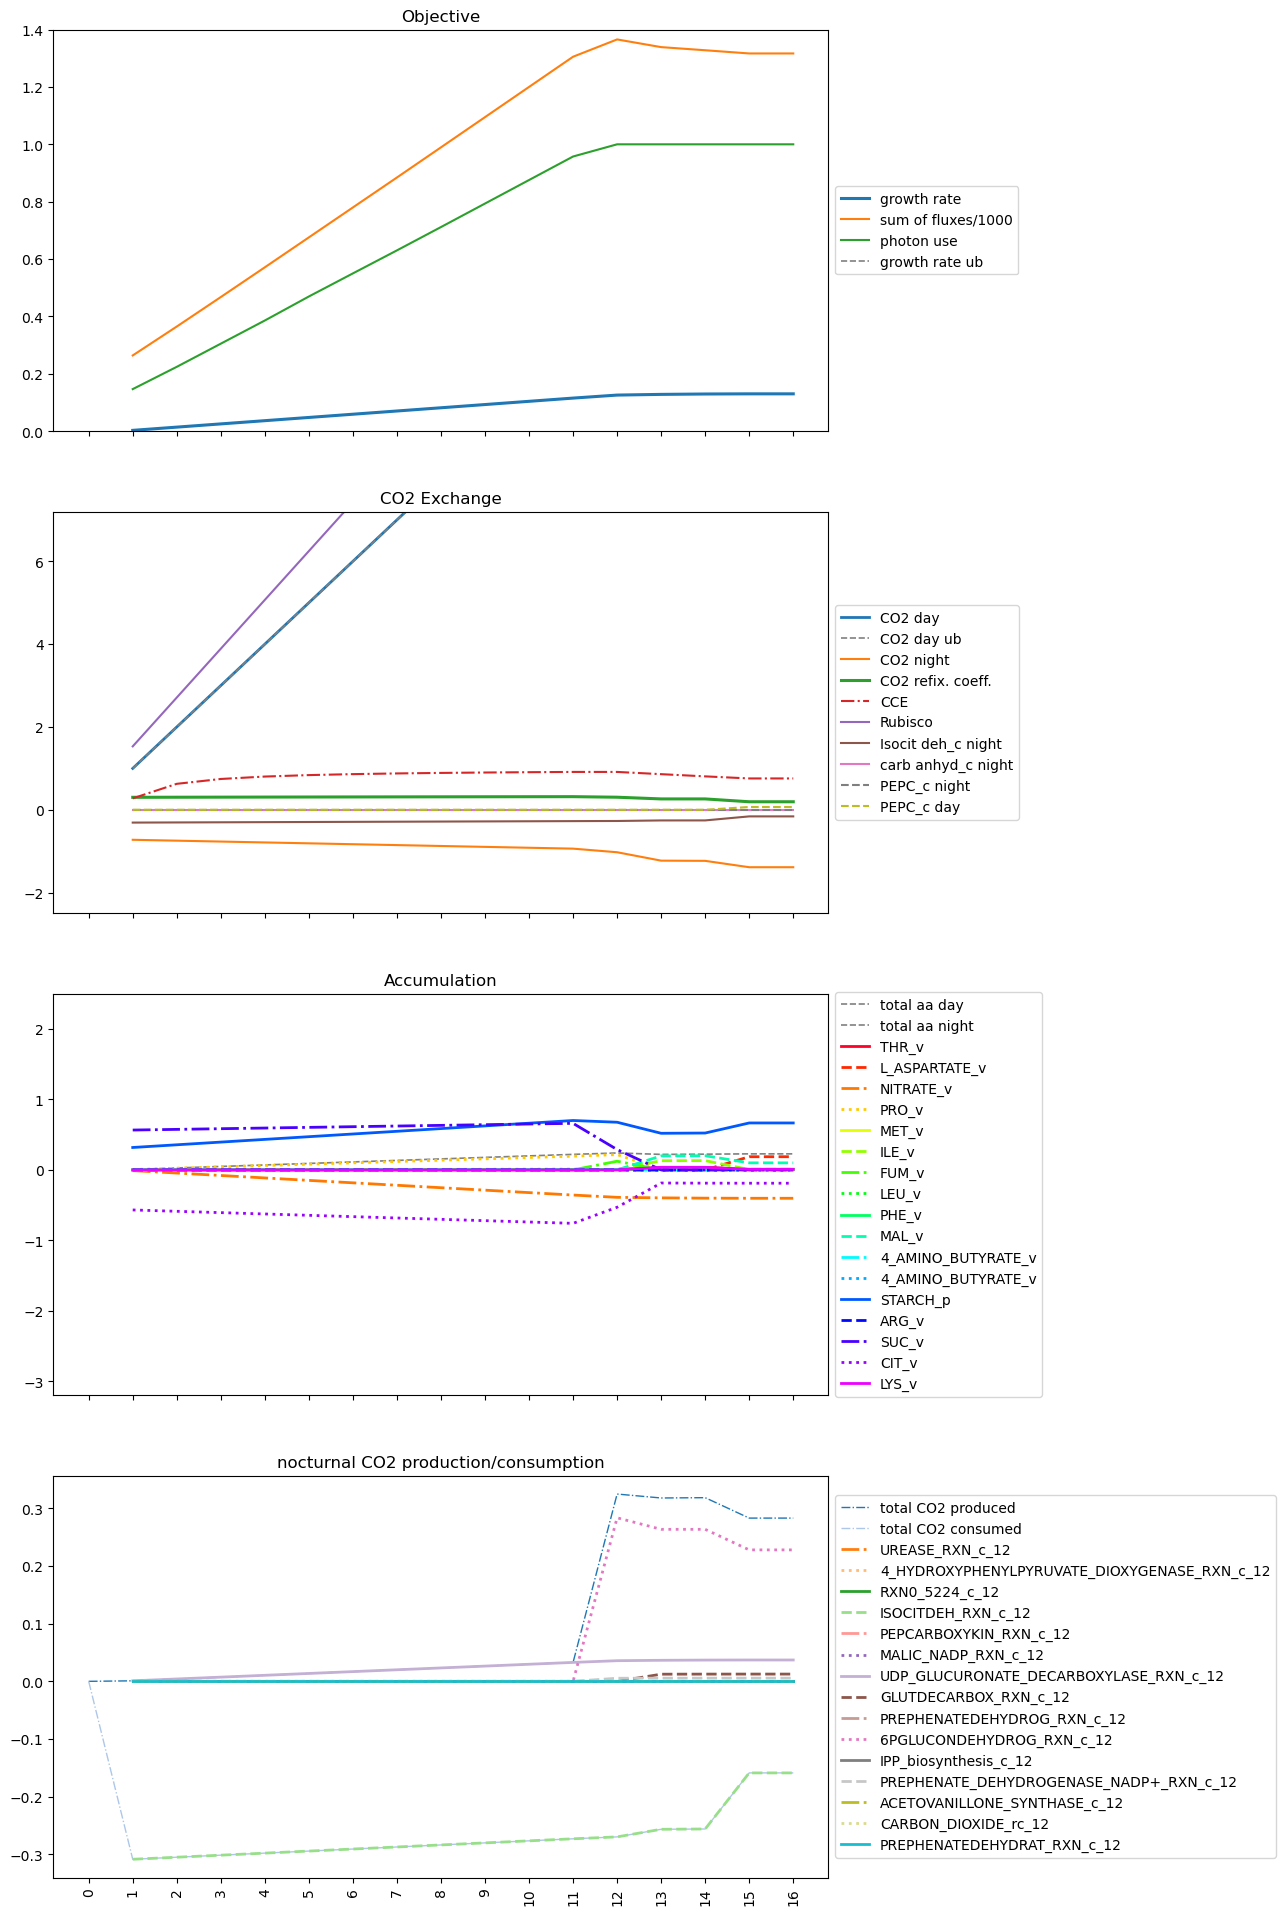

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_CO2, 0.001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

In [ ]:
diel_model_CAM_const = diel_model.copy()



df_diel_model_CAM_const, solution_diel_model_CAM_const = parameter_scan_CO2_CAM(diel_model_CAM_const, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50, double_ub = False, CAM_constraint=True)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------

Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	1.146806
consuming CO2:	RXN0_5224_c_12	1.146806
producing CO2:	CO2_pc_12	0.154728
consuming CO2:	ISOCITDEH_RXN_c_12	-0.036407
producing CO2:	CO2_mc_12	0.855554
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.172931
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.146806
----- Plastid -----
consuming CO2:	CO2_pc_12	0.154728
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.154728
----- Mitochondrion -----
producing CO2:	ISOCITDEH_RXN_m_12	0.309456
producing CO2:	PYRUVDEH_RXN_m_12	0.273049
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.273049
consuming CO2:	CO2_mc_12	0.855554
----- Peroxisome -----

CO2 produced: 1.18321
CO2 consumed: -1.18321
CO2 exchange: -0.0

nocturnal CO2 refixation coeffient: 1.0
CO2_tx_00 = 0
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
PEPC_o

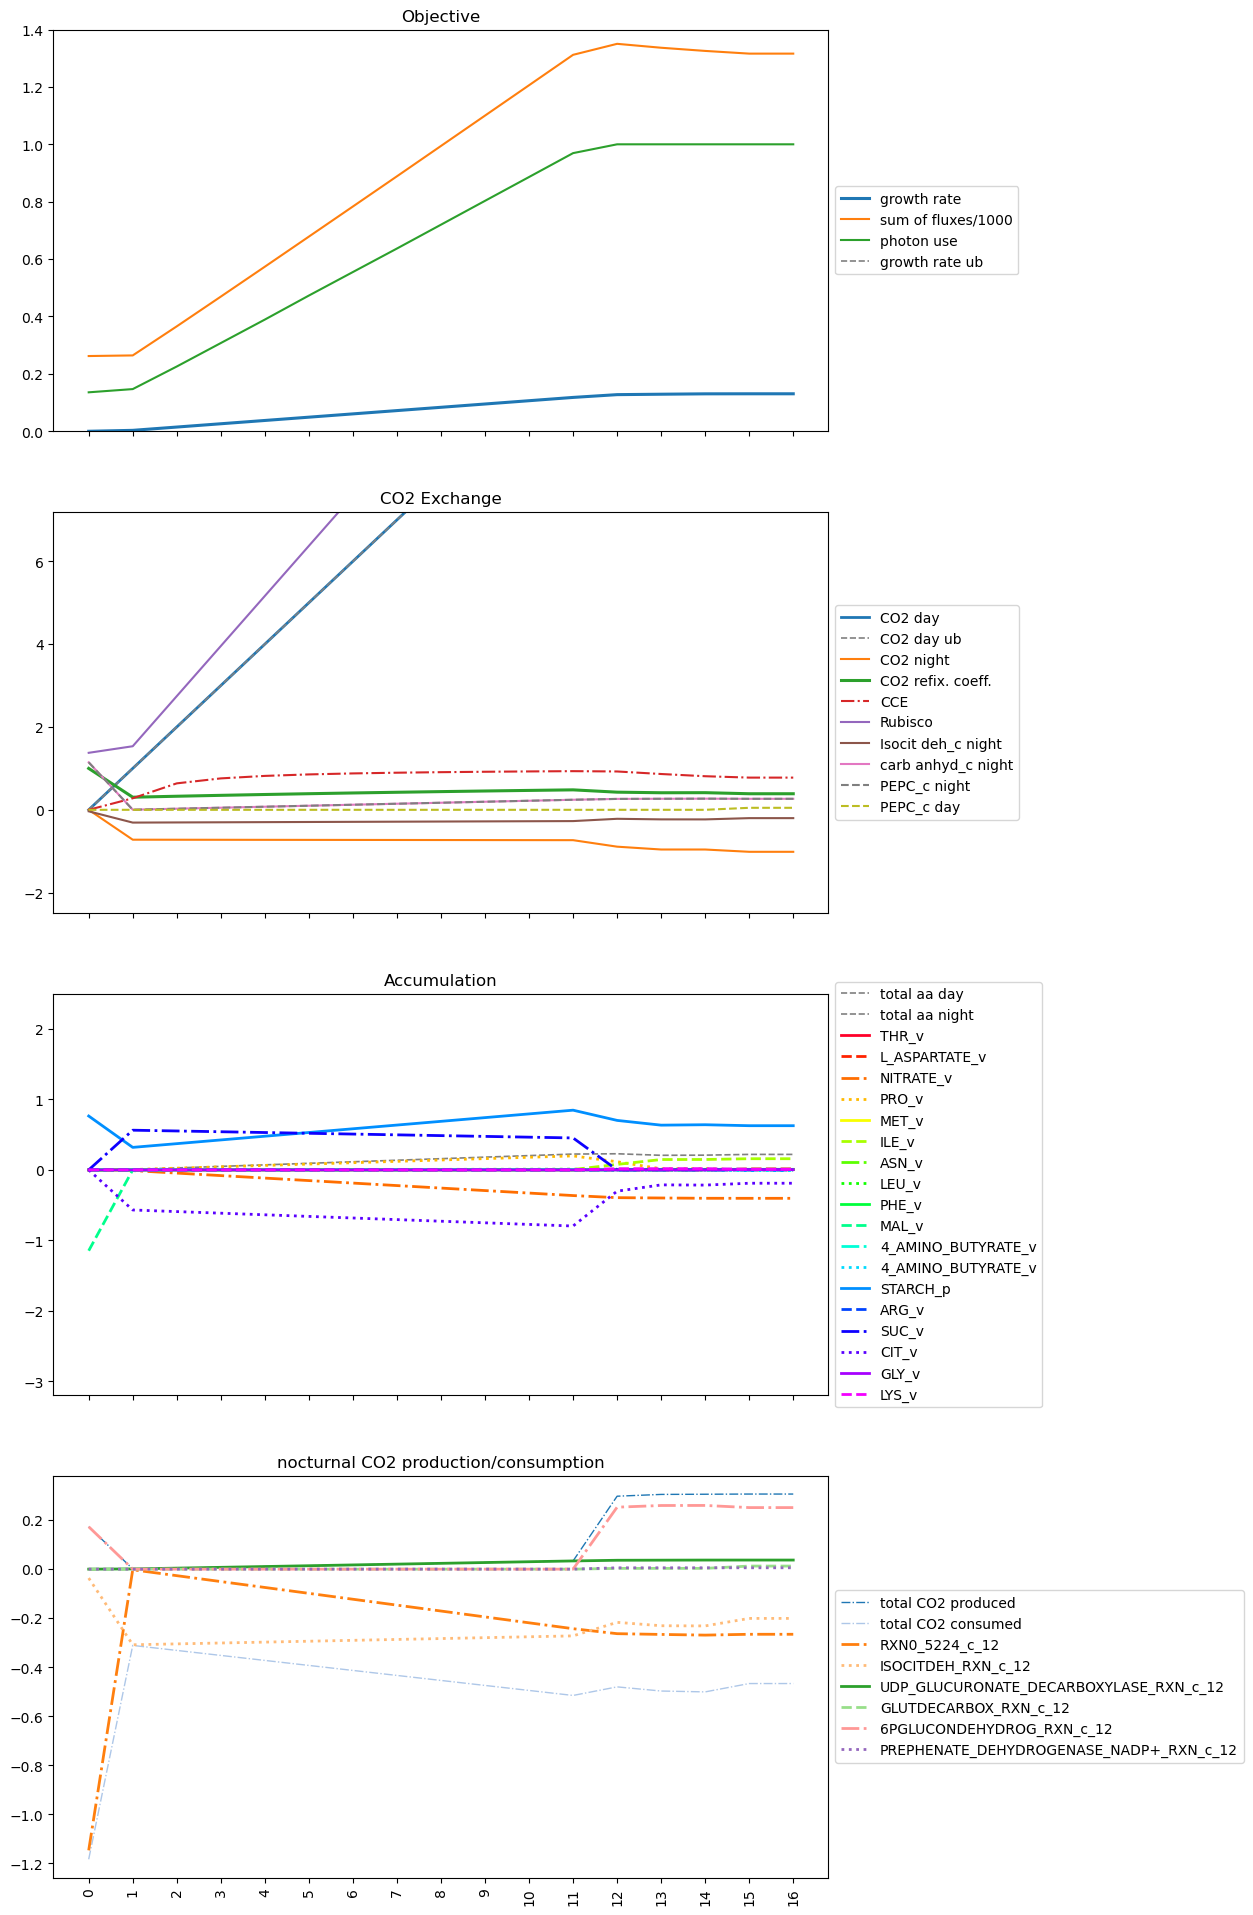

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_CAM_const, 0.001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

In [ ]:
df_diel_model_CAM_const.transpose()["PEPCARBOX_RXN_c_12"]

0     1.146806
1     0.002607
2     0.026637
3     0.050667
4     0.074697
5     0.098727
6     0.122757
7     0.146787
8     0.170817
9     0.194847
10    0.218877
11    0.242908
12    0.263188
13    0.266262
14    0.269057
15    0.265642
16    0.265642
Name: PEPCARBOX_RXN_c_12, dtype: float64

In [ ]:
diel_model_CAM_const_readd = diel_model_CAM_const.copy()

CAM_reactions =  [
                    "PEPCARBOX_RXN_c_12", "PEPCARBOX_RXN_p_12"
                  # ,"ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12"
                 # ,"ISOCITDEH_RXN_m_12", "ISOCITDEH_RXN_c_12", "ISOCITDEH_RXN_x_12"
                 # ,"CARBAMATE_KINASE_RXN_p_12","METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12", "RXN_13202_p_12"
                    ]
# CAM_reactions =  ["ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12"]

for rxn in CAM_reactions:
    temp_rxn = diel_model.reactions.get_by_id(rxn).copy()
    temp_rxn.id = temp_rxn.id+"_CAM"
    diel_model_CAM_const_readd.add_reactions([temp_rxn])



df_diel_model_CAM_const_readd, solution_diel_model_CAM_const_readd = parameter_scan_CO2_CAM(diel_model_CAM_const_readd, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50, double_ub = False, CAM_constraint=True)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
PEPC_obj_const constraint removed
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
PEPC_obj_const constraint removed
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0114886
----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	1.143827
consuming CO2:	RXN0_5224_c_12	1.143827
producing CO2:	CO2_pc_12	0.182587
consuming CO2:	ISOCITDEH_RXN_c_12	-0.078774
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.00326
producing CO2:	GLUTDECARBOX_RXN_c_12	0.000277
producing CO2:	CO2_mc_12	0.842422
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.193566
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.019964
producing CO2:	PREPHENATE_DEHYDROGENASE_NADP+_RXN_c_12	0.000489
consuming HCO3-:	PEPCARBOX_RXN_c_12_CAM	1.123863
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000759
producing CO2:	RX

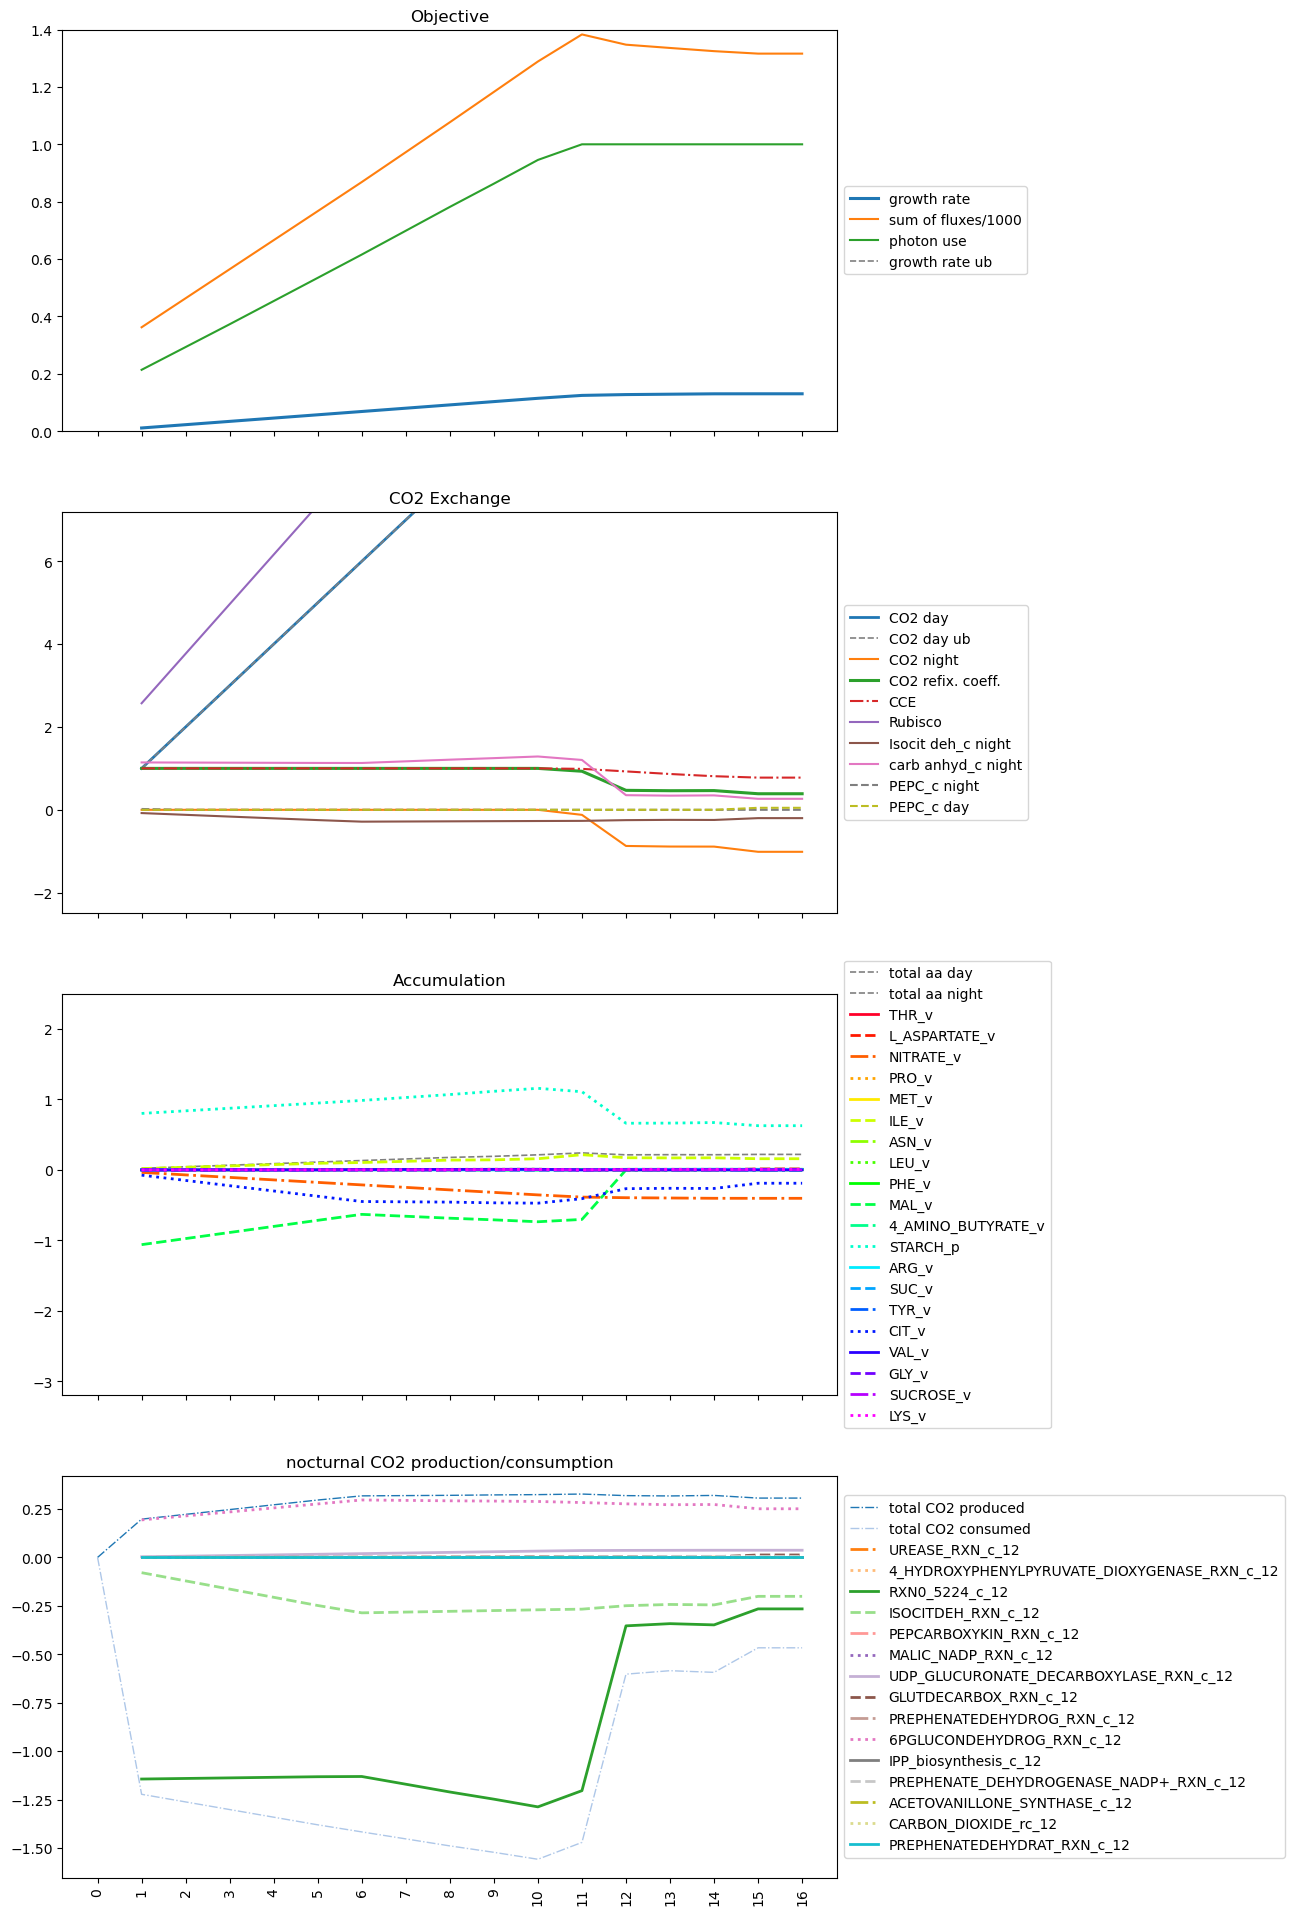

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_CAM_const_readd, 0.001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

#### constraining CO2-involving reacitons in turn

In [ ]:
diel_model_CAM_const.reactions.ISOCITDEH_RXN_m_12

<Reaction ISOCITDEH_RXN_m_12 at 0x7fd2b3e227f0>

In [ ]:
diel_model_CAM_const = diel_model.copy()

diel_model_CAM_const.reactions.ISOCITDEH_RXN_c_12.lower_bound = 0
diel_model_CAM_const.reactions.ISOCITDEH_RXN_m_12.lower_bound = 0
diel_model_CAM_const.reactions.ISOCITDEH_RXN_x_12.lower_bound = 0

diel_model_CAM_const.reactions.METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12.upper_bound = 0



df_diel_model_CAM_const, solution_diel_model_CAM_const = parameter_scan_CO2_CAM(diel_model_CAM_const, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50, double_ub = False, CAM_constraint=True)

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------

Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	1.153565
consuming CO2:	RXN0_5224_c_12	1.153565
producing CO2:	CO2_pc_12	0.171579
producing CO2:	CO2_mc_12	0.827257
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.154728
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.153565
----- Plastid -----
consuming CO2:	CO2_pc_12	0.171579
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.171579
----- Mitochondrion -----
producing CO2:	ISOCITDEH_RXN_m_12	0.275752
producing CO2:	PYRUVDEH_RXN_m_12	0.275752
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.275752
consuming CO2:	CO2_mc_12	0.827257
----- Peroxisome -----

CO2 produced: 1.15356
CO2 consumed: -1.15356
CO2 exchange: -0.0

nocturnal CO2 refixation coeffient: 1.0
CO2_tx_00 = 0
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
PEPC_obj_const constraint removed
Objective: AraCo

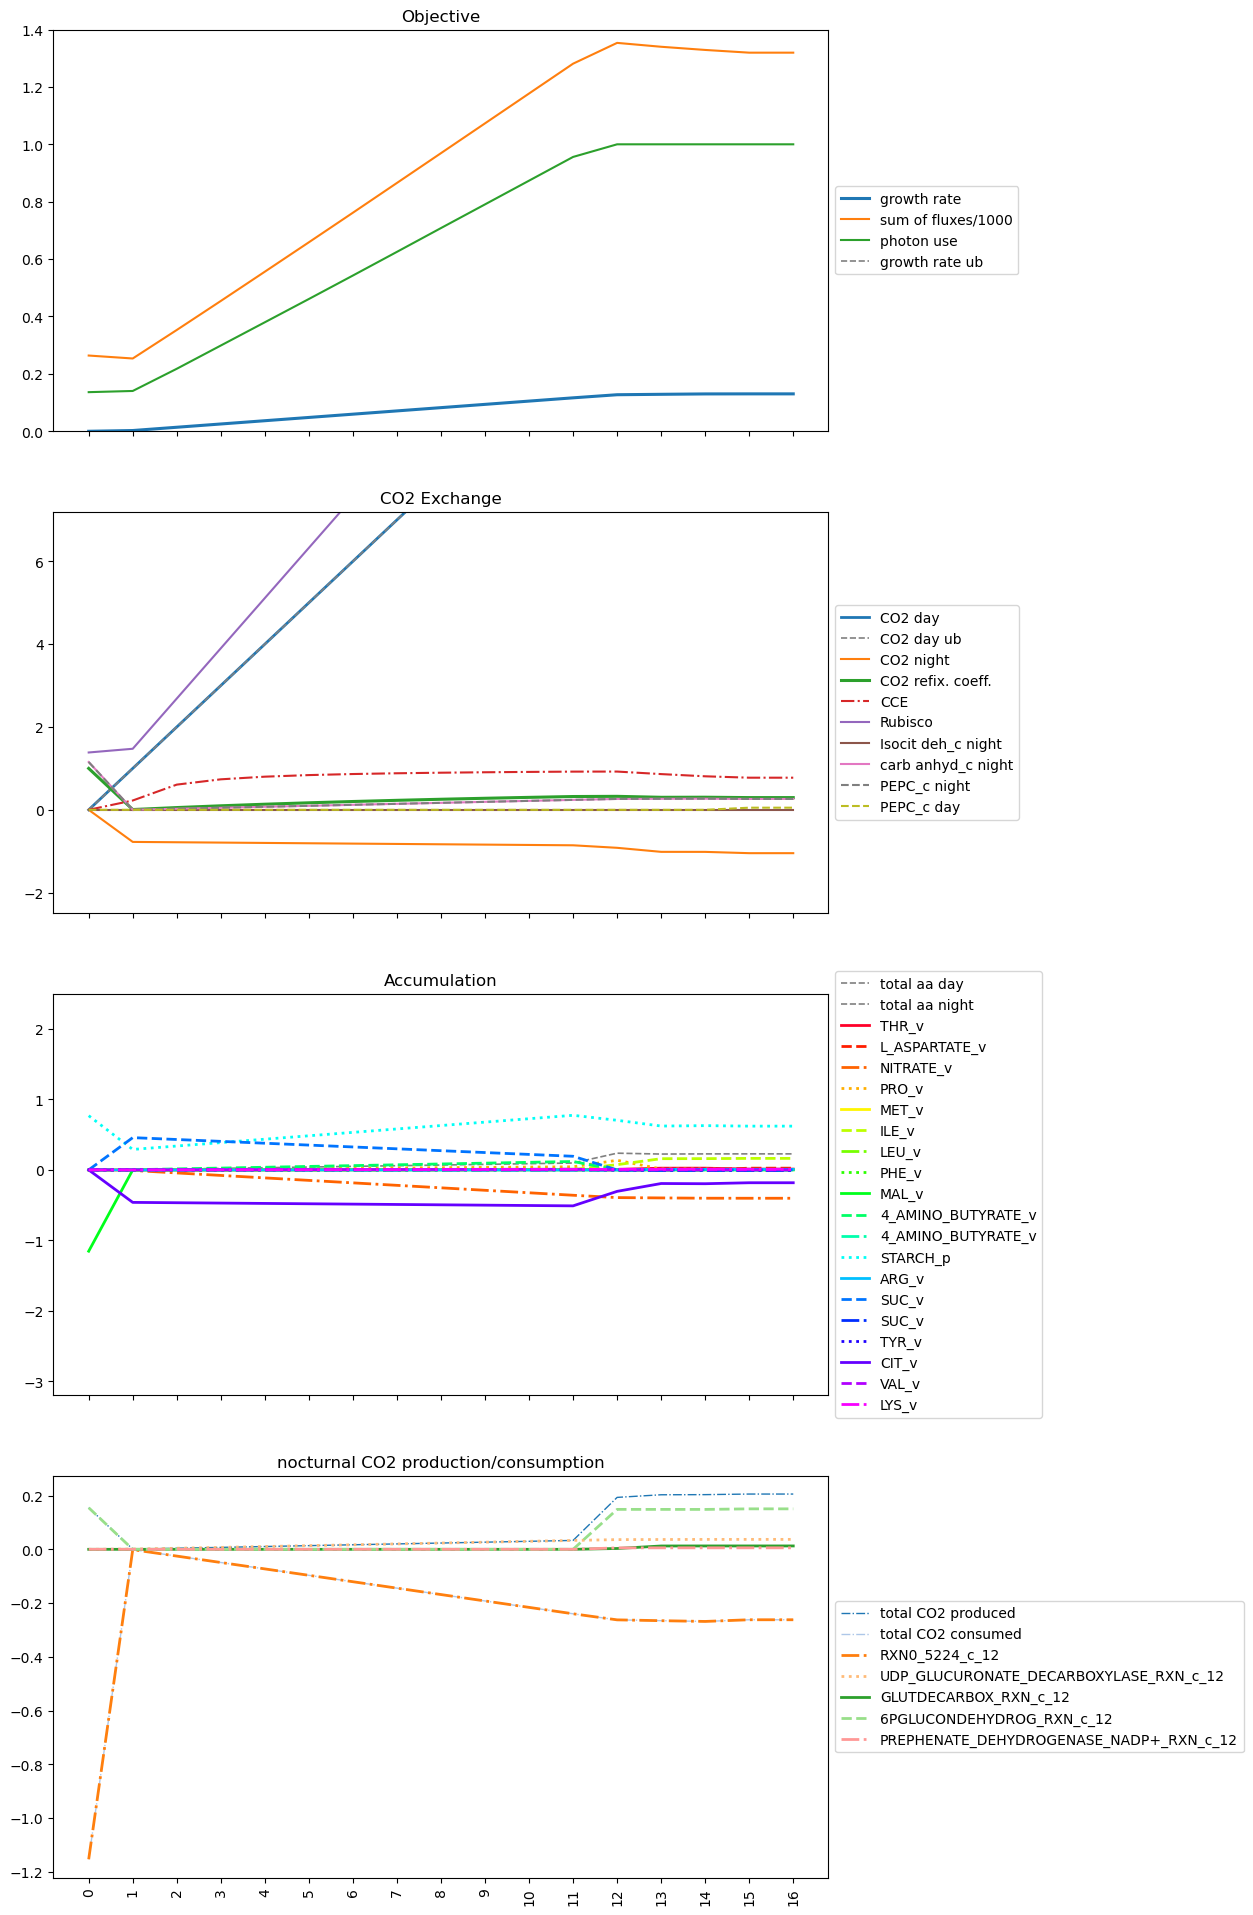

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_CAM_const, 0.001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

In [ ]:
# a function that takes a dataframe like df_diel_model and plots on the x axis the flux through the CO2_tx_00 reaction
# and on the y axis the flux through the output reaction (e.g. AraCore_Biomass_output_tx_total)
import matplotlib.pyplot as plt

def plot_flux(dataframes_dict, output_rxn):
    fig, ax = plt.subplots()
    colors = ['blue', 'orange', 'pink']
    linestyles = ['-', '--', '-.']
    i = 0
    for label, df in dataframes_dict.items():
        df = df.T  # Transpose the dataframe
        ax.plot(df['CO2_tx_00'], df[output_rxn], label=label, color=colors[i], linestyle=linestyles[i % len(linestyles)])
        i += 1
    ax.set_xlabel('Flux through CO2_tx_00')
    ax.set_ylabel(f'Flux through {output_rxn}')
    ax.set_title(f'Flux through CO2_tx_00 vs. Flux through {output_rxn}')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
df_diel_model_CAM.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16'],
      dtype='object')

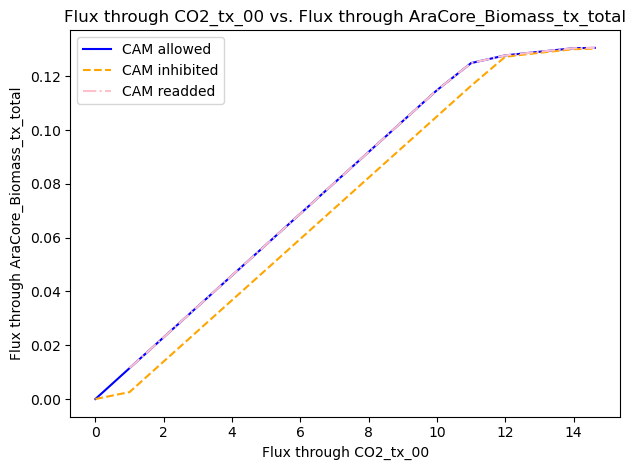

In [ ]:
dfs = {"CAM allowed": df_diel_model_CAM, 
       "CAM inhibited":df_diel_model_CAM_const, 
       "CAM readded":df_diel_model_CAM_const_readd}

plot_flux(dfs, output_string+"_total")


In [ ]:
%run functions.py

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0
----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	1.146806
consuming CO2:	RXN0_5224_c_12	1.146806
producing CO2:	CO2_pc_12	0.154728
consuming CO2:	ISOCITDEH_RXN_c_12	-0.036407
producing CO2:	CO2_mc_12	0.855554
producing CO2:	6PGLUCONDEHYDROG_RXN_c_12	0.172931
consuming HCO3-:	PEPCARBOX_RXN_c_12	1.146806
----- Plastid -----
consuming CO2:	CO2_pc_12	0.154728
producing CO2:	6PGLUCONDEHYDROG_RXN_p_12	0.154728
----- Mitochondrion -----
producing CO2:	ISOCITDEH_RXN_m_12	0.309456
producing CO2:	PYRUVDEH_RXN_m_12	0.273049
producing CO2:	2OXOGLUTARATEDEH_RXN_m_12	0.273049
consuming CO2:	CO2_mc_12	0.855554
----- Peroxisome -----

CO2 produced: 1.18321
CO2 consumed: -1.18321
CO2 exchange: 0.0

nocturnal CO2 refixation coeffient: 1.0
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Bio

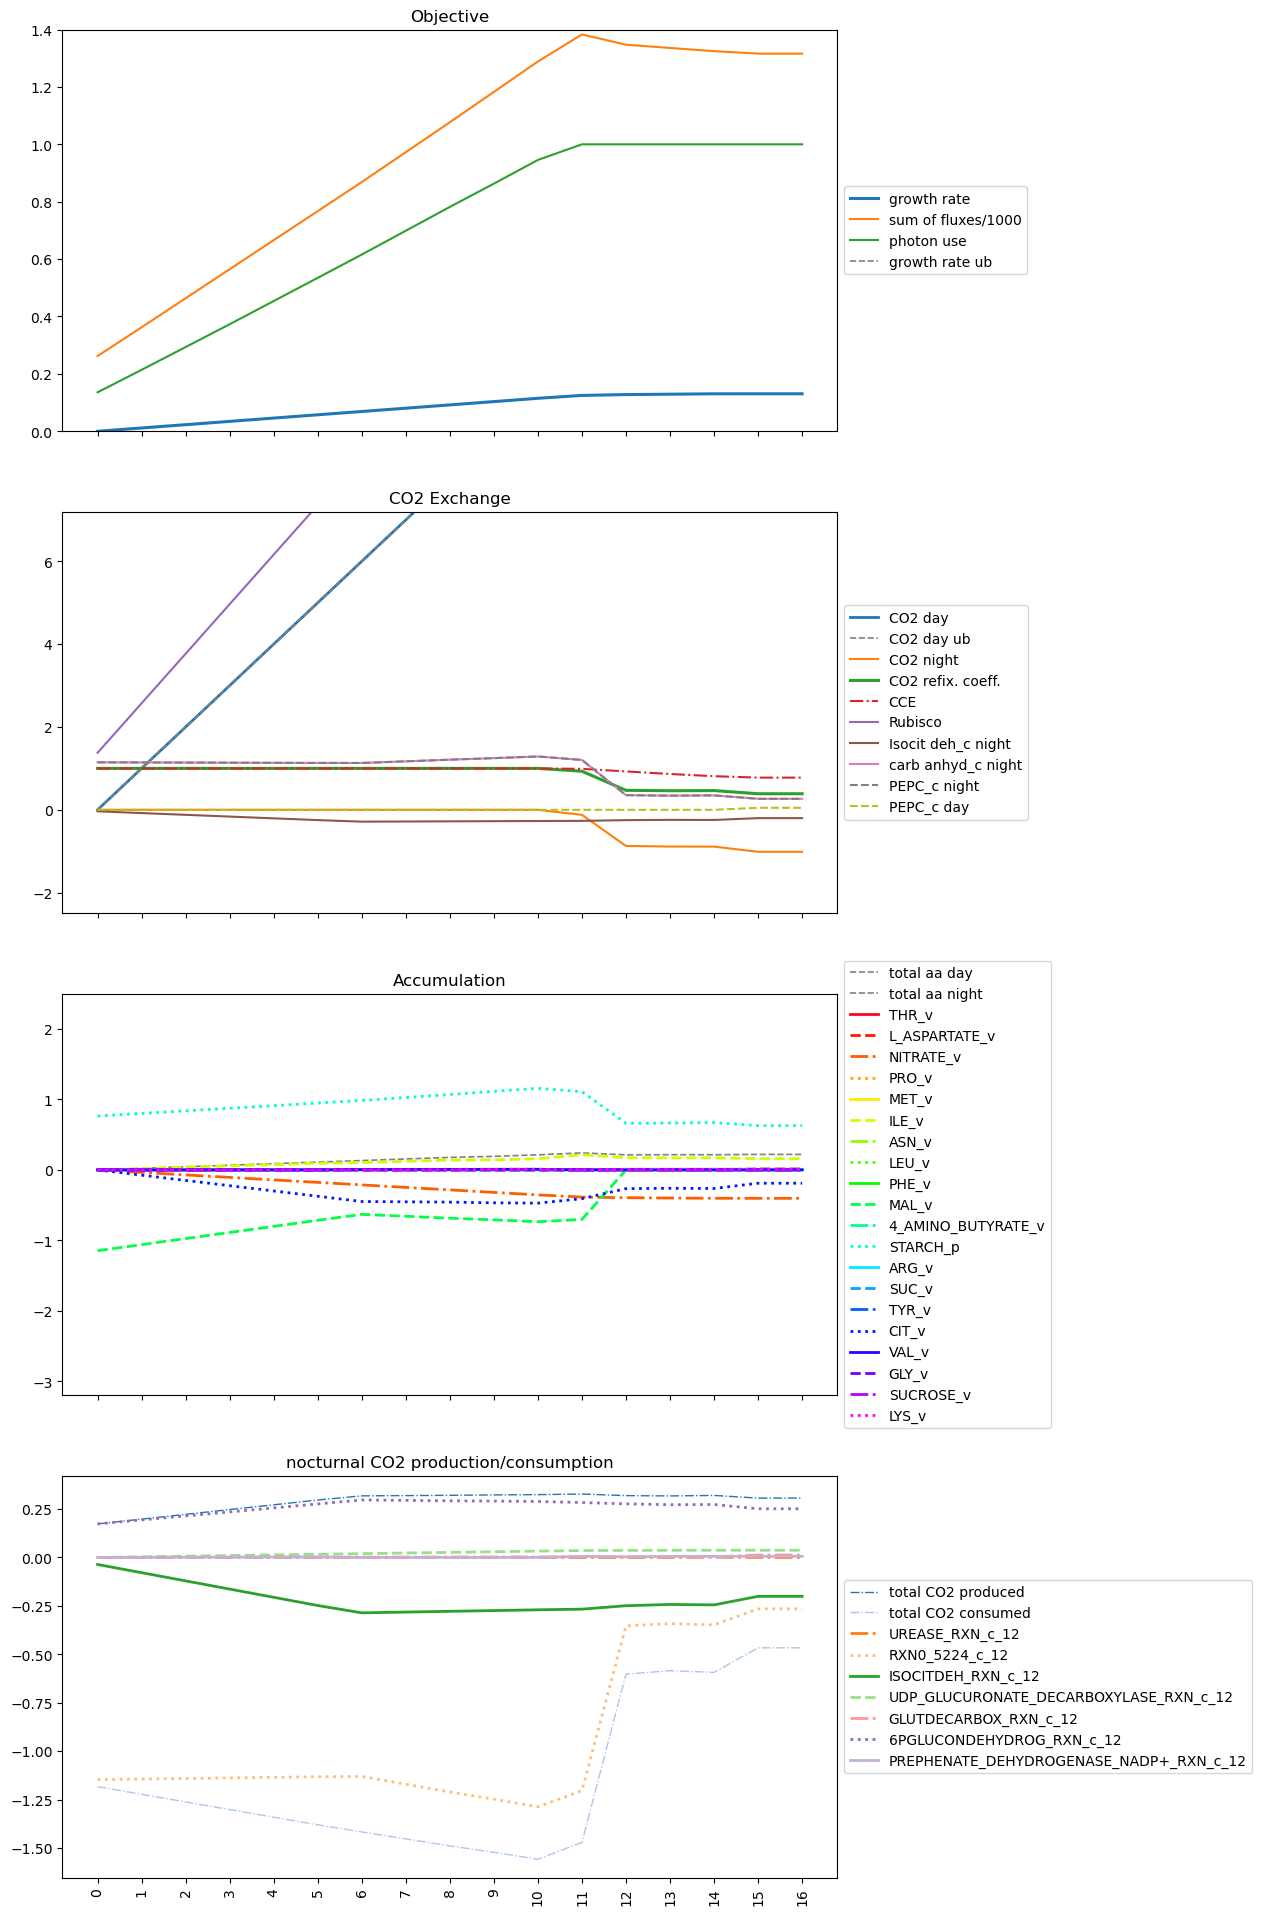

In [ ]:
df_diel_model_CO2, solution_diel_model_CO2 = parameter_scan_CO2(diel_model, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)

plot_accum(diel_model, output_string+"_total", df_diel_model_CO2, 0.001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

In [ ]:
set_PEPC_C3_constraints(diel_model, slope=2.094050238268857, objective = output_string+"_total")

(2.094050238268857, '')

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0031999
----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	0.002607
consuming CO2:	RXN0_5224_c_12	0.002607
producing CO2:	CO2_pc_12	0.16264
consuming CO2:	ISOCITDEH_RXN_c_12	-0.308445
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.000908
producing CO2:	CO2_mc_12	0.868973
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.002607
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000211
producing CO2:	RXN_9652_p_12	0.000617
producing CO2:	RXN_9650_p_12	0.000617
producing CO2:	RXN_5682_p_12	0.000136
producing CO2:	2.3.1.180_RXN_p_12	0.000617
producing CO2:	RXN_9654_p_12	0.000617
producing HCO3-:	RXN0_5224_p_12	0.004318
consuming CO2:	RXN0_5224_p_12	0.004318
consuming CO2:	CO2_

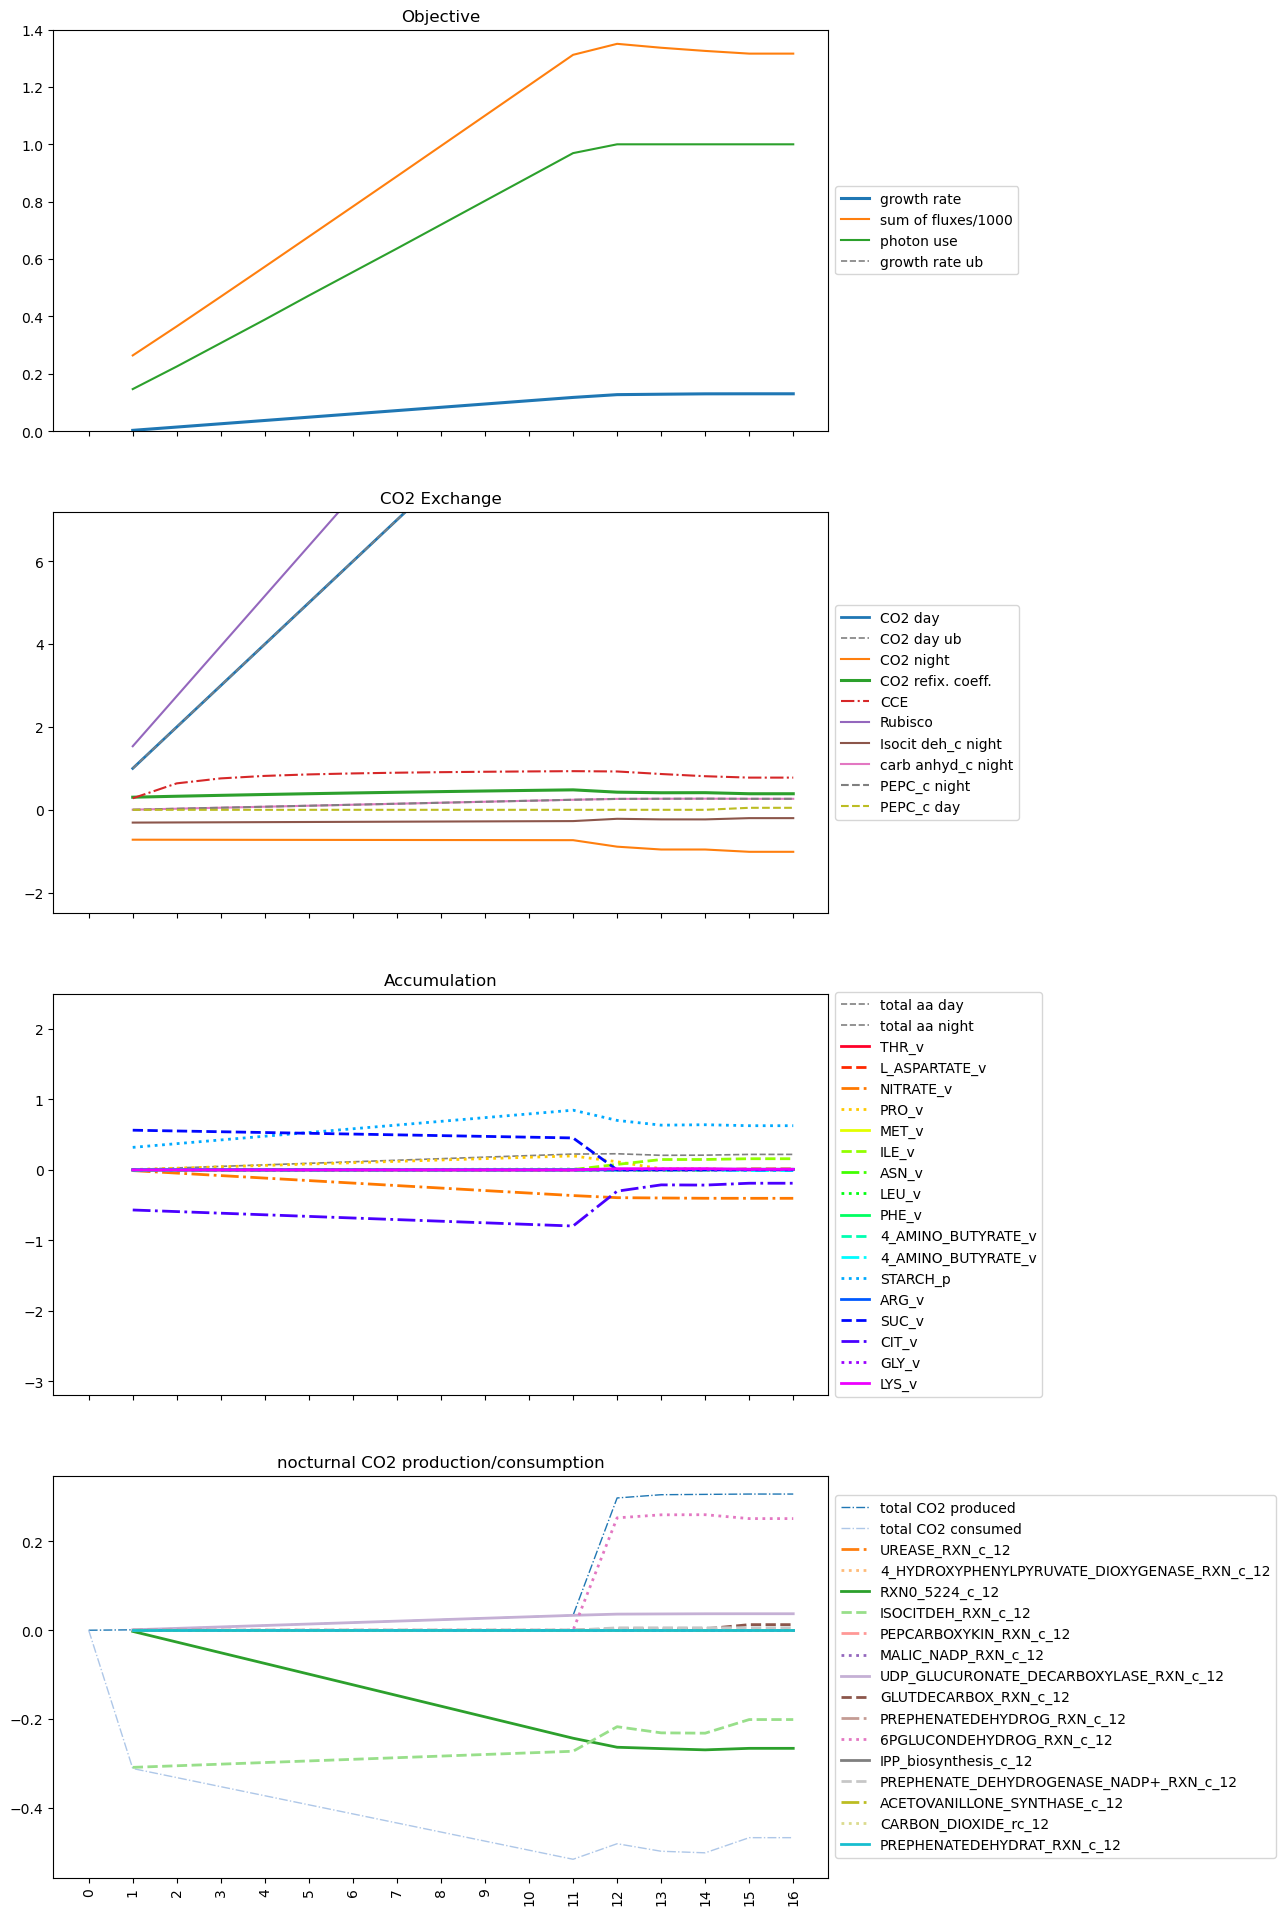

In [ ]:
df_diel_model_CO2, solution_diel_model_CO2 = parameter_scan_CO2(diel_model, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)

plot_accum(diel_model, output_string+"_total", df_diel_model_CO2, 0.001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c"])

In [ ]:
diel_model.reactions.ISOCITDEH_RXN_c_12

<Reaction ISOCITDEH_RXN_c_12 at 0x7fd2d6ff2b80>

Scanning process: CO2_tx_00 

------- Scan iteration: 1      Scan value: 0 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration is infeasible!
------- Scan iteration: 2      Scan value: 1 (CO2_tx_00) --------
Objective: AraCore_Biomass_tx_total
Model iteration feasible. Objective flux: 0.0029842
----- Cytosol -----
producing HCO3-:	RXN0_5224_c_12	0.002155
consuming CO2:	RXN0_5224_c_12	0.002155
producing CO2:	CO2_pc_12	0.162011
consuming CO2:	CO2_xc_12	-0.154257
producing CO2:	UDP_GLUCURONATE_DECARBOXYLASE_RXN_c_12	0.000847
producing CO2:	CO2_mc_12	0.7338
consuming HCO3-:	PEPCARBOX_RXN_c_12	0.002155
----- Plastid -----
producing CO2:	DIAMINOPIMDECARB_RXN_p_12	0.000197
producing CO2:	RXN_9652_p_12	0.000575
producing CO2:	RXN_9650_p_12	0.000575
producing CO2:	RXN_5682_p_12	0.000127
producing CO2:	2.3.1.180_RXN_p_12	0.000575
producing CO2:	RXN_9654_p_12	0.000575
producing HCO3-:	RXN0_5224_p_12	0.004027
consuming CO2:	RXN0_5224_p_12	0.004027
consuming CO2:	CO2_pc_12	0.16

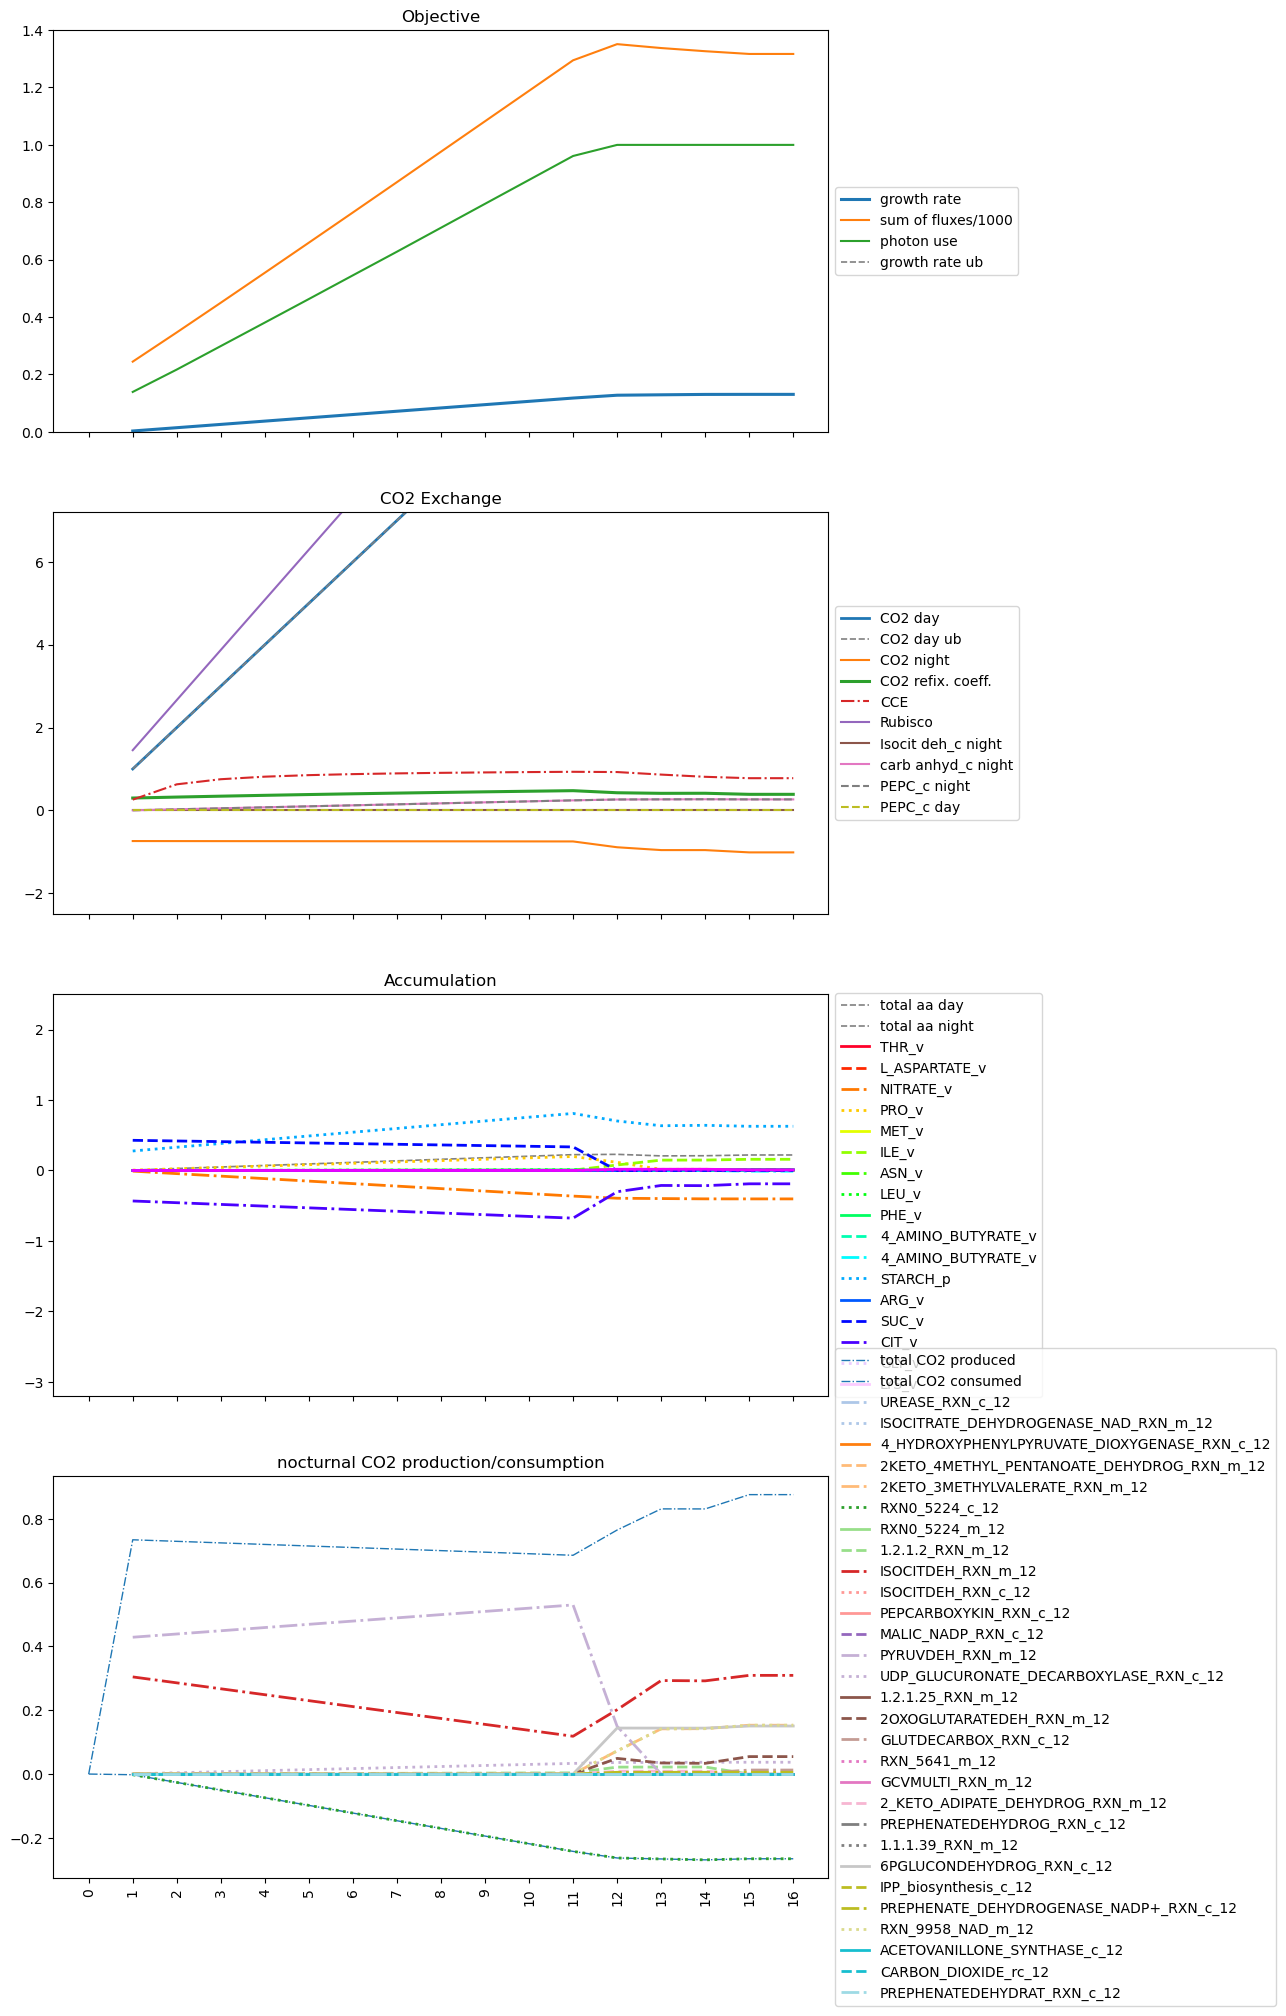

In [ ]:
diel_model.reactions.ISOCITDEH_RXN_c_12.lower_bound = 0


df_diel_model_CO2, solution_diel_model_CO2 = parameter_scan_CO2(diel_model, output_string+"_total", "CO2_tx_00", 
                   0, 17, 1, pFBA=True, CO2_refixation_allowed=True, 
                   verbose=True, iterations=50)

plot_accum(diel_model, output_string+"_total", df_diel_model_CO2, 0.001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_c", "_m"])

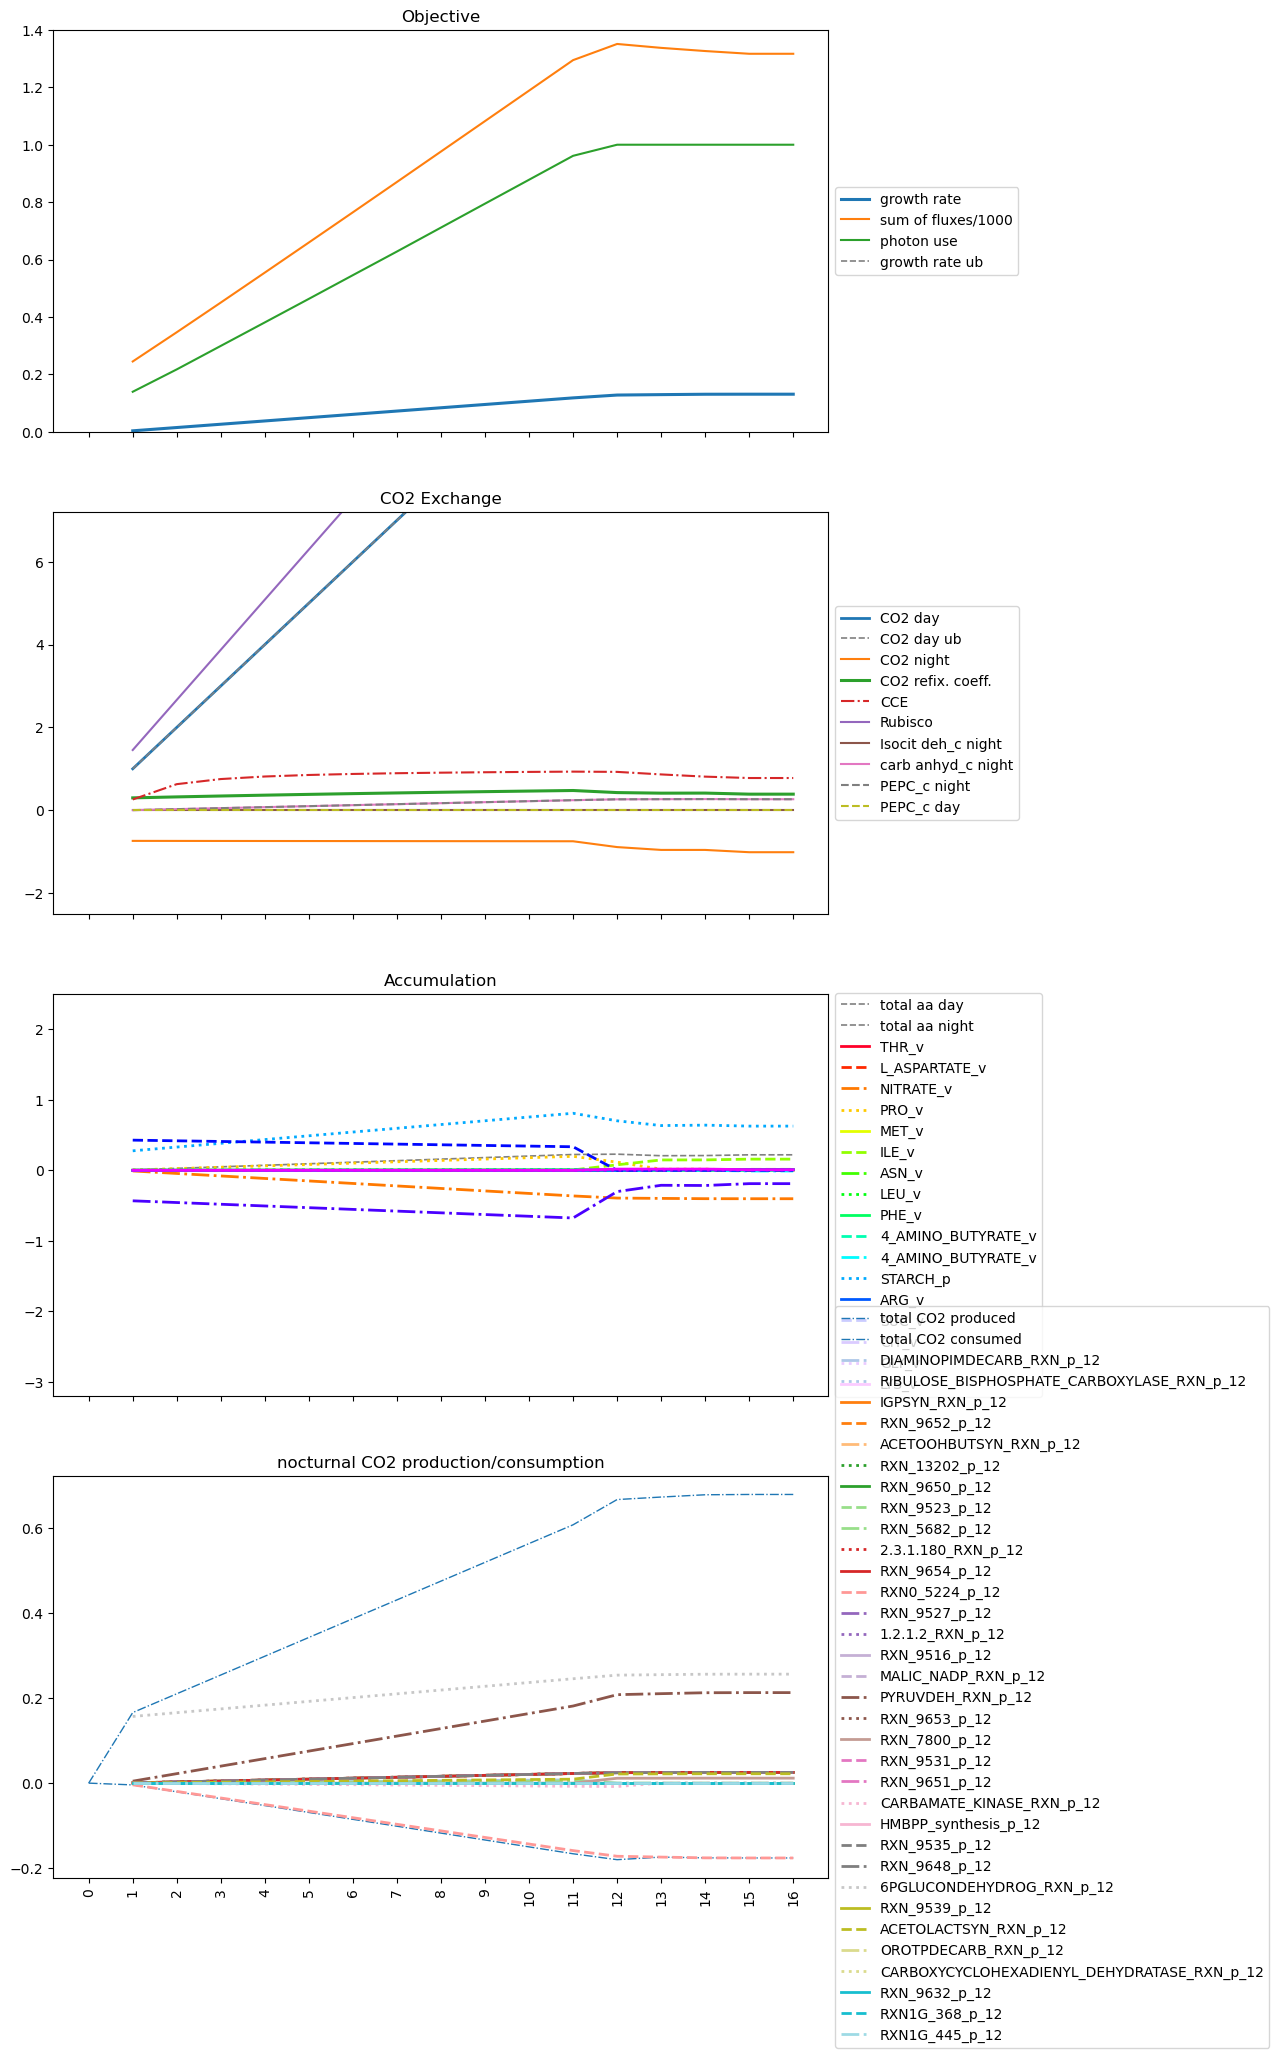

In [ ]:
plot_accum(diel_model, output_string+"_total", df_diel_model_CO2, 0.001, growth_rate=[1,1], CO2_day_rate=[1.16,1.16], lim2_x=0, lim2_y=1.4, lim3_x=-2.5, lim3_y=7.2, lim5_x=-3.2, 
           lim5_y=2.5, time_phase="_12", CO2_organelle = ["_p"])

In [ ]:
diel_model

<Model PlantCoreMetabolism_v2_1_0_PlantCoreMetabolism_v2_1_0 at 0x7fd2db0f7b80>

In [ ]:
generateNADHbudget(model_no_cetch,solution_no_cetch,show_plot=True,percentage=False,day_or_night_tag="_12")

NameError: name 'generateNADHbudget' is not defined

Total: 1.6494442786427124


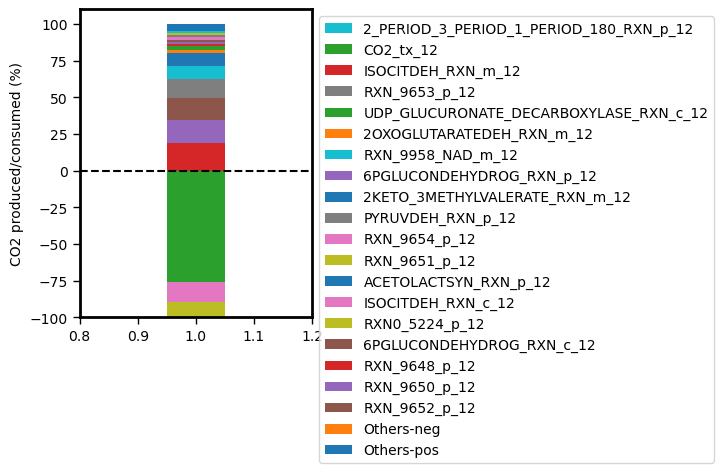

In [ ]:
generateCO2budget(model_no_cetch,solution_no_cetch,show_plot=True,percentage=True,day_or_night_tag="_12")

### adding a CO2 constraint

In [ ]:
CO2_uptake = 1.16
# CO2_uptake = 0.794

model_no_cetch_CO2 = model_no_cetch.copy()

model_no_cetch_CO2.reactions.CO2_tx_00.upper_bound = CO2_uptake

In [ ]:
solution_no_cetch_CO2 = flux_analysis.parsimonious.pfba(model_no_cetch_CO2)


In [ ]:
model_no_cetch_CO2.reactions.get_by_id(output_string +"_total").flux

0.09209024310335565

In [ ]:
solution_no_cetch_CO2

<Solution 1778.825 at 0x7ff5907ca130>

In [ ]:
model_no_cetch_CO2.reactions.get_by_id(output_string+"_total").flux

0.09209024310335565

In [ ]:
model_no_cetch_CO2.reactions.CO2_tx_00.flux

1.16

In [ ]:
model_results_overview(model_no_cetch_CO2, solution_no_cetch_CO2, output_string+"_total")

Photon uptake = 200.0    % of allowed Photon uptake = 100.0
Output rate ( AraCore_Biomass_tx_total ) 0.0921 		sum of fluxes: 1778.8247
gas exchange = Day: 1.16 	Night: 6.81929
CO2_tx at night is taking up CO2.
ATPase:  3.7651 2.7851
Rubisco Carbox./Oxygen. =  12.8849 / 4.295
Photorespiratory CO2 losses=  0.0 / mitochondrial CO2 export= 0.0

Linker fluxes 		 Day 	 Night
TRP_v_linker                         0.0       0.0
THR_v_linker                     0.00476       0.0
GLY_v_linker                         0.0       0.0
bHIS_v_linker                        0.0       0.0
SUCROSE_v_linker                     0.0                 0.0
LEU_v_linker                         0.0       0.0
ILE_v_linker                     0.16321       0.0
STARCH_p_linker                  5.56734                 0.0
FRU_v_linker                         0.0                 0.0
FUM_v_linker                         0.0                 0.0
LYS_v_linker                         0.0       0.0
ASN_v_linker               

## carbon-salvaging behaviour analysis

In [ ]:
temp_model2 = plant_with_pathway_model.copy()

scan_value = 10


temp_model2.reactions.get_by_id("CO2_tx_00").bounds = (0, scan_value)
                    
temp_model2.reactions.get_by_id("ISOCITDEH_RXN_m_12").bounds = (0.30945555555555543, 1000)
temp_model2.reactions.get_by_id("ISOCITDEH_RXN_c_12").bounds = (scan_value*-0.005637521436444347-0.12872795468818982, 1000)
temp_model2.reactions.get_by_id("ISOCITDEH_RXN_x_12").bounds = (0, 0)
# temp_model2.reactions.get_by_id("RXN0_5224_p_12").bounds = (0, scan_value*0.013837003396037719-0.015729553171368718)
# temp_model2.reactions.get_by_id("RXN0_5224_c_12").bounds = (0, 0)
temp_model2.reactions.get_by_id("RXN_13202_p_12").bounds = (0, 0)
temp_model2.reactions.get_by_id("CARBAMATE_KINASE_RXN_p_12").bounds = (0, 0)
temp_model2.reactions.get_by_id("PEPCARBOX_RXN_c_12").bounds = (0, 0)
temp_model2.reactions.get_by_id("PEPCARBOX_RXN_p_12").bounds = (0, 0)
# temp_model2.reactions.get_by_id("ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12").bounds = (0, scan_value*0.013837003396037701-0.015729553171368163) #obj_constrained
# temp_model2.reactions.get_by_id("ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12").bounds = (0, scan_value*0.015574986923339373) #CAM
ratio = 1.34951668565
ACCT_const = temp_model2.problem.Constraint(
                        (ratio*temp_model2.reactions.get_by_id(output_string+"_total").flux_expression) - 
                        (temp_model2.reactions.ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12.flux_expression), 
                        lb = 0,
                        ub= 0,
                        name="ACCT_const")
temp_model2.add_cons_vars(ACCT_const)

temp_model2.reactions.get_by_id("METHYLCROTONYL_COA_CARBOXYLASE_RXN_m_12").bounds = (0, 0)


In [ ]:
solution1 = flux_analysis.parsimonious.pfba(temp_model2)
print(temp_model2.reactions.AraCore_Biomass_tx_total.flux)
print(temp_model2.reactions.MAL_v_linker_12_to_00.flux)
print(temp_model2.reactions.CIT_v_linker_12_to_00.flux)
print(temp_model2.reactions.SUC_v_linker_00_to_12.flux)


print("ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12", temp_model2.reactions.get_by_id("ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12").flux)

0.10815688618351597
7.312260270419032
0.0
7.1503288316132965
ACETYL_COA_CARBOXYLTRANSFER_RXN_p_12 0.14595952257260272


In [ ]:
solution1.fluxes.tail(60)

RXN_16391_x_00                             0.000000e+00
RXN_8958_x_00                              0.000000e+00
RXN_18381_x_00                             1.115655e+01
RXN_8960_x_00                             -7.382295e+00
4_HYDROXY_BUTYRATE_cp_00                   0.000000e+00
4_HYDROXY_BUTYRYL_COA_cp_00               -4.115637e+00
CPD_9407_cp_00                             0.000000e+00
CPD_9408_cp_00                             0.000000e+00
CPD_9406_cp_00                            -7.382295e+00
CPD_17635_cp_00                            0.000000e+00
CPD_9409_cp_00                             0.000000e+00
METHYL_MALONYL_COA_cp_00                   1.149793e+01
4_HYDROXY_BUTYRATE_cm_00                   5.354590e+00
4_HYDROXY_BUTYRYL_COA_cm_00               -5.052854e-15
CPD_9407_cm_00                            -3.148465e+00
CPD_9408_cm_00                             3.148465e+00
CPD_9406_cm_00                             0.000000e+00
CPD_17635_cm_00                            0.000